# About Dataset

Data source: https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction/data?select=Clean_Dataset.csv

Dataset contains information about flight booking options from the website Easemytrip for flight travel between India's top 6 metro cities. There are 300261 datapoints and 11 features in the cleaned dataset.

Description:
* `Date`: The date when tickets are available
* `Airline:` The name of the airline company is stored in the airline column. It is a categorical feature having 8 different airlines.
* `Flight:` Flight stores information regarding the plane's flight code. It is a categorical feature.
* `Source City:` City from which the flight takes off. It is a categorical feature having 6 unique cities.
* `Departure Time:` This is a derived categorical feature obtained created by grouping time periods into bins. It stores information about the departure time and have 6 unique time labels.
* `Stop:` A categorical feature with 3 distinct values that stores the number of stops between the source and destination cities.
* `Arrival Time:` This is a derived categorical feature created by grouping time intervals into bins. It has six distinct time labels and keeps information about the arrival time.
* `Destination City:` City where the flight will land. It is a categorical feature having 6 unique cities.
* `Class:` A categorical feature that contains information on seat class; it has two distinct values: Business and Economy.
* `Duration:` A continuous feature that displays the overall amount of time it takes to travel between cities in hours.
* `Days Left:` This is a derived characteristic that is calculated by subtracting the trip date by the booking date.
* `Price:` Target variable stores information of the ticket price.

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
from matplotlib import pyplot as plt
from jcopml.tuning import grid_search_params as gsp, random_search_params as rsp
from scipy.stats import randint, uniform

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline

In [2]:
# Models Library
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso #gud
from sklearn.linear_model import Lars
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet #gud
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.svm import SVR
from sklearn.svm import NuSVR #gud
from sklearn.svm import LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.cross_decomposition import PLSRegression
# ==========  Non-Linear Regressor  ==========================
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [3]:
# Color Palettes
#AEDFF2 (Light Blue)
#7EC0EE (Sky Blue)
#5CACEE (Steel Blue)
#4682B4 (Royal Blue)
#2E6AA3 (Sapphire Blue)
#1C1C1C (Midnight Blue)

# Data Preprocessing

In [96]:
# Import the data
data = pd.read_csv('Clean_Dataset.csv')
data.drop(['Unnamed: 0'], axis=1, inplace=True)
df = data.copy()

# Check the data
print('Data shape   :', data.shape)
print('Duplicates   :', data[data.duplicated()].shape[0])
print('NULL values  :', data.isnull().sum().sum())
empty_strings = data.apply(lambda col: (col == '').sum())
print('Empty strings:', empty_strings.sum())
data.head()

Data shape   : (300153, 11)
Duplicates   : 0
NULL values  : 0
Empty strings: 0


,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


- The data has 300,153 records and 11 variables.
- None of the duplicates, null, and empty strings were found.

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB


- All data types are correct. We will need to transform it before the processing step.

In [98]:
# Descriptive Statistics
df.describe()

,duration,days_left,price
count,300153.000000,300153.000000,300153.000000
mean,12.221021,26.004751,20889.660523
std,7.191997,13.561004,22697.767366
min,0.830000,1.000000,1105.000000
25%,6.830000,15.000000,4783.000000
50%,11.250000,26.000000,7425.000000
75%,16.170000,38.000000,42521.000000
max,49.830000,49.000000,123071.000000


- Big gap between median and mean on variable price indicating the presence of outliers.
- Both variables price and duration have its mean value than its median, indicating right-skewed distribution. This was proven by the visualization below.

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


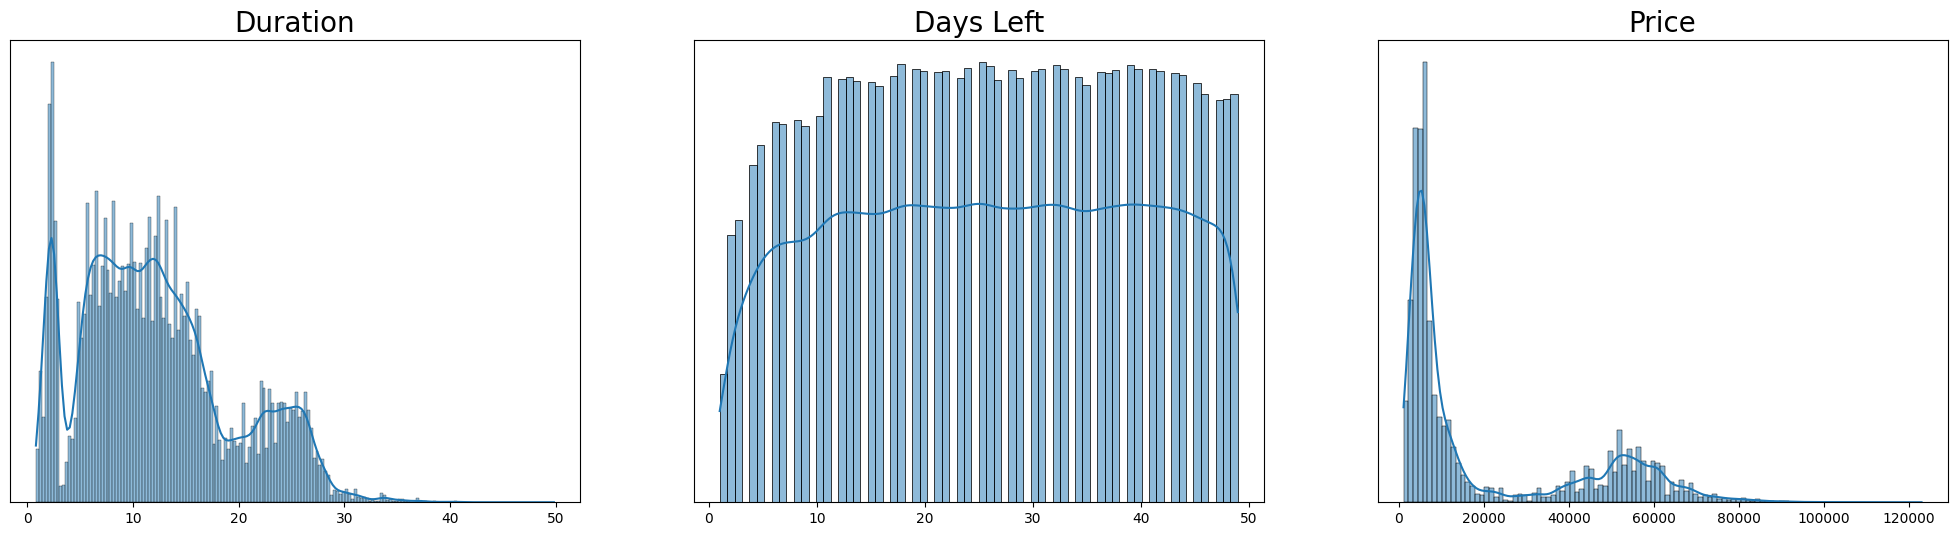

In [99]:
# Data Distribution
plt.subplots(ncols=3, nrows=1, figsize=(25, 6))

plt.subplot(131)
sns.histplot(df['duration'], kde=True)
plt.title('Duration', fontsize=20)
plt.xlabel('')
plt.xlabel('')
plt.ylabel('')
plt.yticks([])

plt.subplot(132)
sns.histplot(df['days_left'], kde=True)
plt.title('Days Left', fontsize=20)
plt.xlabel('')
plt.xlabel('')
plt.ylabel('')
plt.yticks([])

plt.subplot(133)
sns.histplot(df['price'], kde=True)
plt.title('Price', fontsize=20)
plt.xlabel('')
plt.ylabel('')
plt.yticks([])

plt.show()

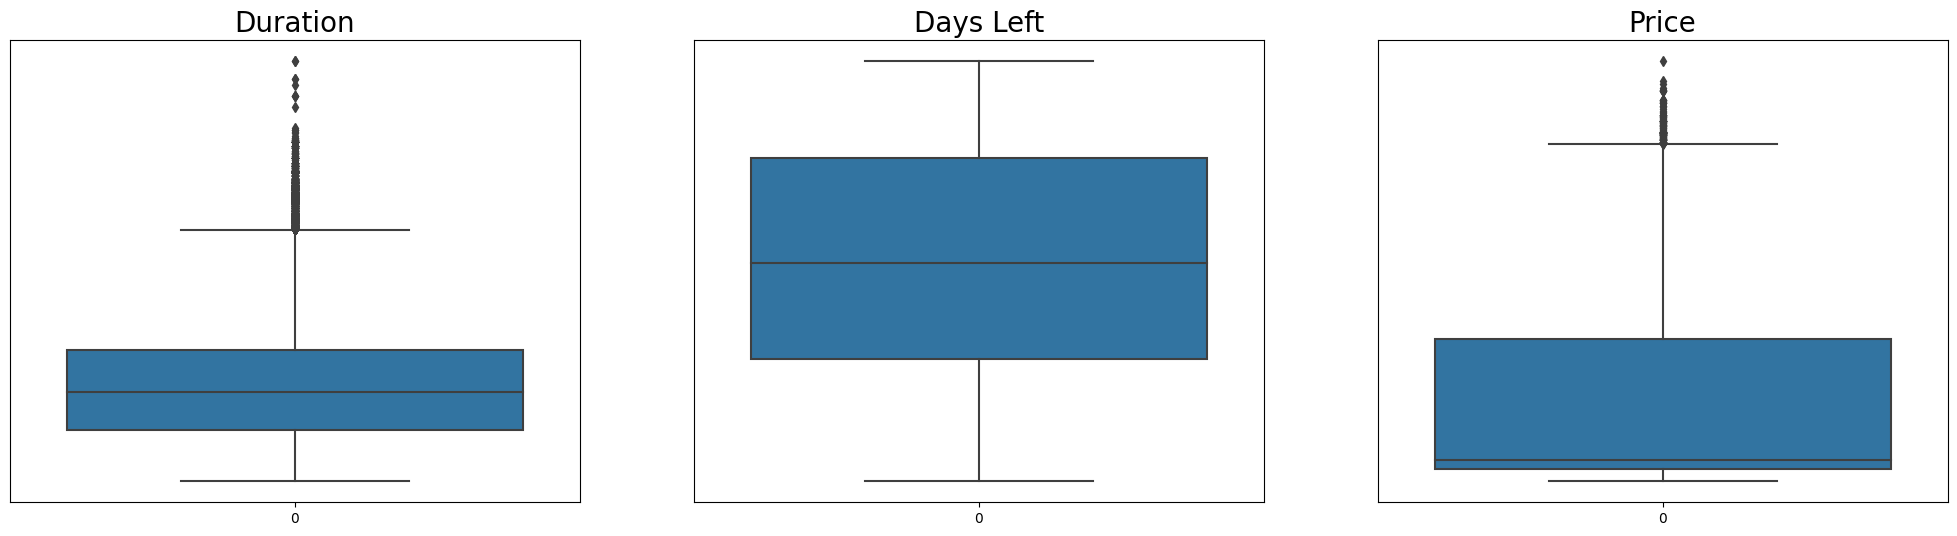

In [100]:
# Detecting Outliers
plt.subplots(ncols=3, nrows=1, figsize=(25, 6))

plt.subplot(131)
sns.boxplot(df['duration'])
plt.title('Duration', fontsize=20)
plt.xlabel('')
plt.ylabel('')
plt.yticks([])

plt.subplot(132)
sns.boxplot(df['days_left'])
plt.title('Days Left', fontsize=20)
plt.xlabel('')
plt.ylabel('')
plt.yticks([])

plt.subplot(133)
sns.boxplot(df['price'])
plt.title('Price', fontsize=20)
plt.xlabel('')
plt.ylabel('')
plt.yticks([])

plt.show()

- As previously assumed, there are outliers present on both variables duration and price.
- Outliers detected above the upperbound of the variables.

**Outliers Handling**

Outliers handling will be done in stages. The first step will involve outliers removal based on the price column. Subsequently, the remaining outliers will be removed based on duration column.

In [101]:
# Removing Outliers on price (1st step)
q1 = df['price'].quantile(0.25)
q3 = df['price'].quantile(0.75)
IQR = q3 - q1
upper_bound = q3 + 1.5 * IQR
lower_bound = q1 - 1.5 * IQR

print('Number of Outliers   :', df[(df['price'] > upper_bound) | (df['price'] < lower_bound)].shape[0])
df = df[(df['price'] <= upper_bound) & (df['price'] >= lower_bound)]
print('Cleaned Dataset Shape:', df.shape)
df.head()

Number of Outliers   : 123
Cleaned Dataset Shape: (300030, 11)


,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [102]:
# Removing Outliers on duration (2nd step)
q1 = df['duration'].quantile(0.25)
q3 = df['duration'].quantile(0.75)
IQR = q3 - q1
upper_bound = q3 + 1.5 * IQR
lower_bound = q1 - 1.5 * IQR

print('Number of Outliers   :', df[(df['duration'] > upper_bound) | (df['duration'] < lower_bound)].shape[0])
df = df[(df['duration'] <= upper_bound) & (df['duration'] >= lower_bound)]
print('Cleaned Dataset Shape:', df.shape)
df.head()

Number of Outliers   : 2110
Cleaned Dataset Shape: (297920, 11)


,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


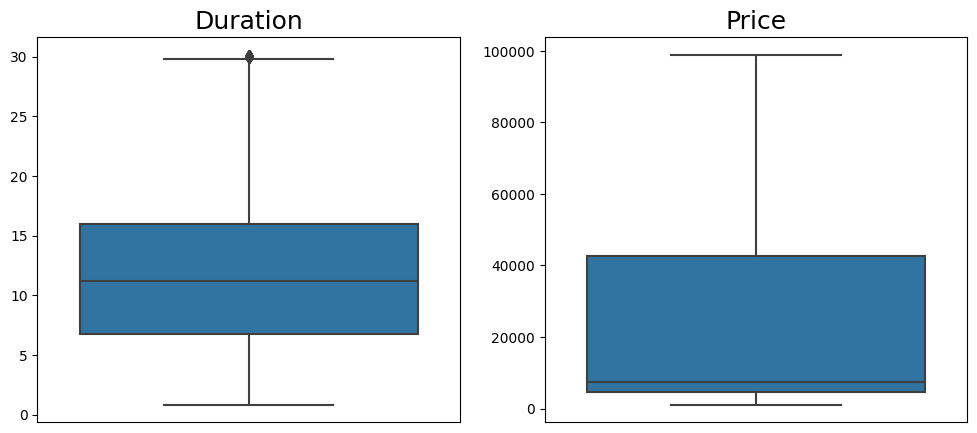

In [103]:
plt.subplots(ncols=2, nrows=1, figsize=(12, 5))

plt.subplot(121)
sns.boxplot(df['duration'])
plt.title('Duration', fontsize=18)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])

plt.subplot(122)
sns.boxplot(df['price'])
plt.title('Price', fontsize=18)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.show()

- The presence of outliers still detected above the upperbound of duration. We will ignore these outliers as their number is fewer than previously observed.

# Exploratory Data Analysis

In [12]:
#AEDFF2 (Light Blue)
#7EC0EE (Sky Blue)
#5CACEE (Steel Blue)
#4682B4 (Royal Blue)
#2E6AA3 (Sapphire Blue)
#1C1C1C (Midnight Blue)

### How does price vary by class?

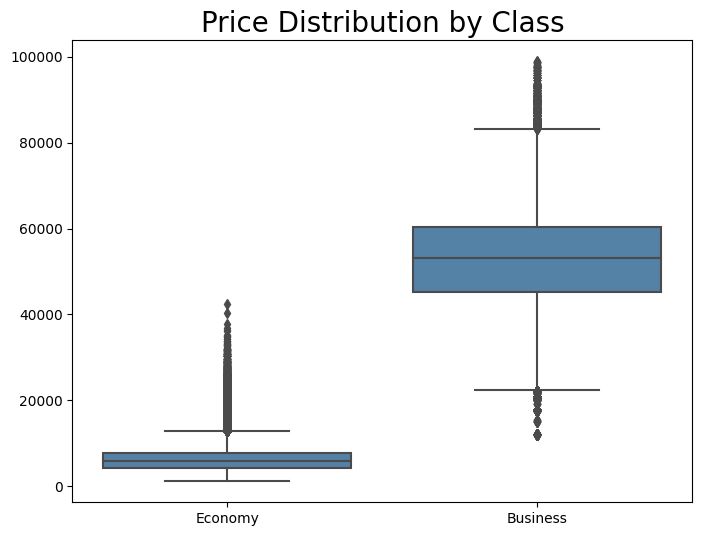

In [13]:
my_palette = {'#4682B4'}
plt.figure(figsize=(8, 6))
sns.boxplot(x='class', y='price', data=df, palette=my_palette)
plt.title('Price Distribution by Class', fontsize=20)
plt.xlabel('')
plt.ylabel('')
plt.show()

- Class significantly influences prices, with business class generally commanding higher prices due to the noticeable differences in service and amenities offered.

### How does pricce vary by airlines?

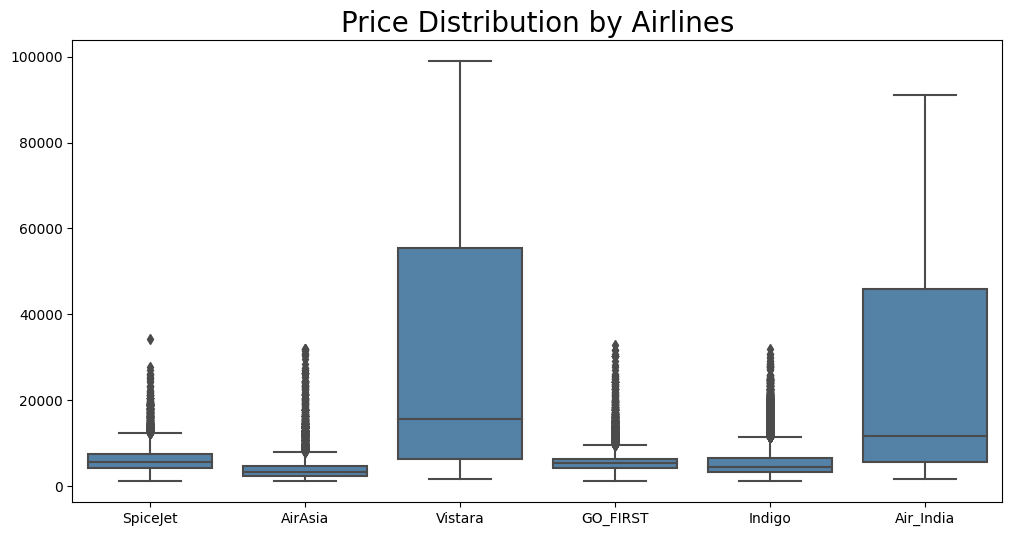

In [14]:
my_palette = {'#4682B4'}
plt.figure(figsize=(12, 6))
sns.boxplot(x='airline', y='price', data=df, palette=my_palette)
plt.title('Price Distribution by Airlines', fontsize=20)
plt.xlabel('')
plt.ylabel('')
plt.show()

- Air India and Vistara are the most expensive airlines based on its price distribution.

### How does price vary by airlines' class?

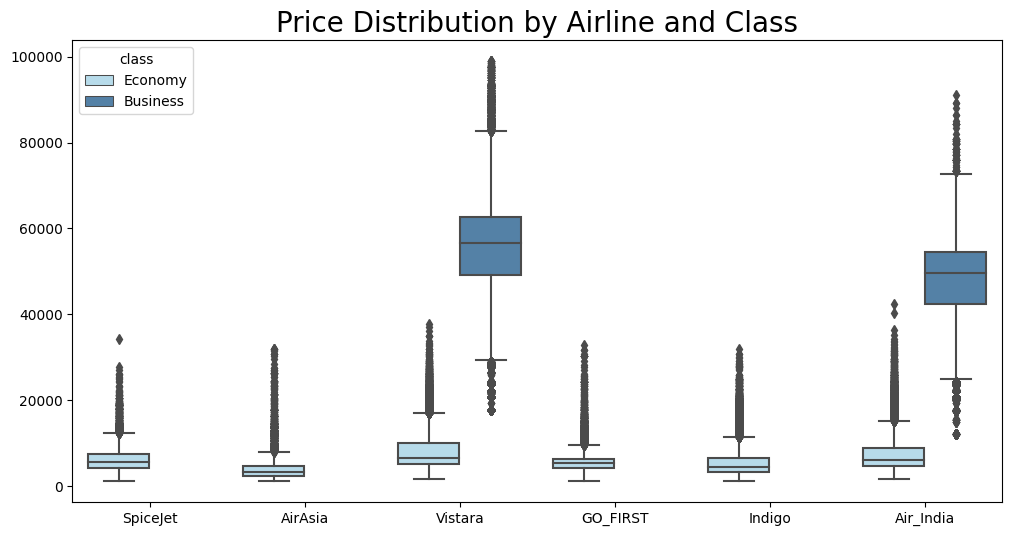

In [15]:
my_palette = {'Business': '#4682B4', 'Economy': '#AEDFF2'}
plt.figure(figsize=(12, 6))
sns.boxplot(x='airline', y='price', data=df, hue='class', palette=my_palette)
plt.title('Price Distribution by Airline and Class', fontsize=20)
plt.xlabel('')
plt.ylabel('')
plt.show()

- Air India and Vistara are the most expensive airlines even though the business class excluded.
- A big noticable gap between Air India and Vistara and the other airlines exists because only Air India and Vistara offered business class flight.
- Price distribution among each class is pretty similar.

### What is the most expensive airline by its average price?

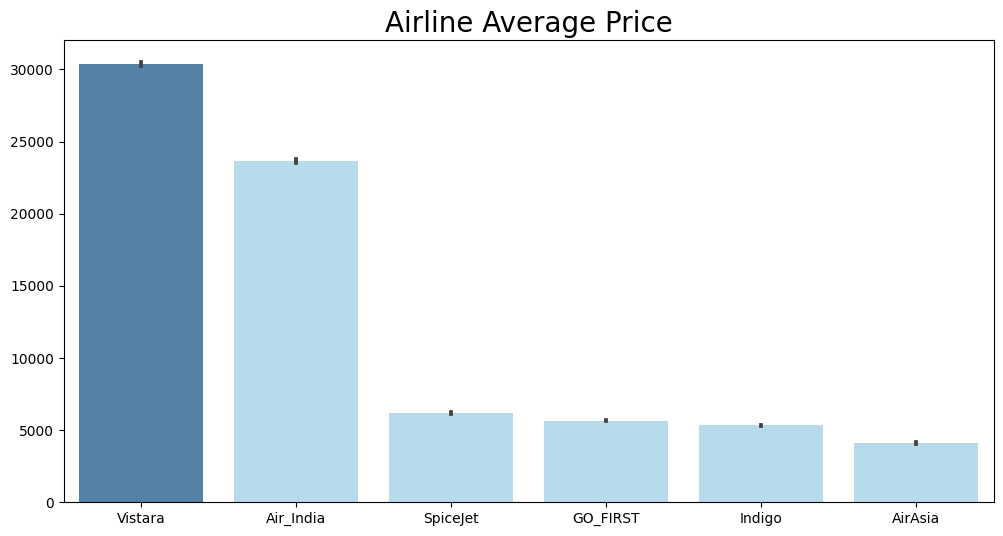

In [16]:
my_palette = ['#4682B4', '#AEDFF2', '#AEDFF2', '#AEDFF2', '#AEDFF2', '#AEDFF2']
plt.figure(figsize=(12, 6))
sns.barplot(x='airline', y='price', data=df, palette=my_palette, estimator=np.mean, order=df.groupby('airline')['price'].mean().sort_values(ascending=False).index)
plt.title('Airline Average Price', fontsize=20)
plt.xlabel('')
plt.ylabel('')
plt.show()

### How does price vary by days before flight?

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25124\1704129525.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='days_left', y='price', data=df, marker='o', errorbar=None, palette=my_palette)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


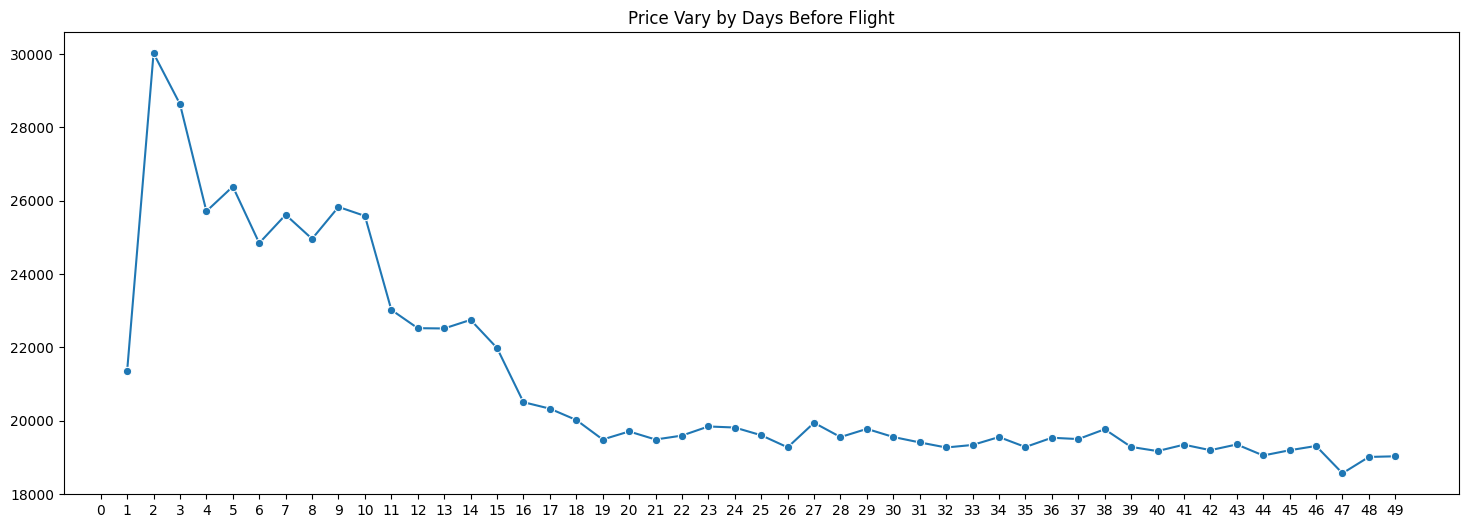

In [104]:
my_palette = {'#4682B4'}
plt.figure(figsize=(18, 6))
sns.lineplot(x='days_left', y='price', data=df, marker='o', errorbar=None, palette=my_palette)
plt.title('Price Vary by Days Before Flight')
plt.ylabel('')
plt.xlabel('')
plt.xticks(np.arange(0, 50, 1))
plt.show()

- Peak average price ticket is on two days before flight.
- If a customer bought a ticket 15 days or more before flight, they will get a chaper price.

**Price vs Days Left by Class**

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25124\3061340015.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='days_left', y='price', data=df[df['class']=='Economy'], marker='o', errorbar=None, palette=my_palette)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25124\3061340015.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assig

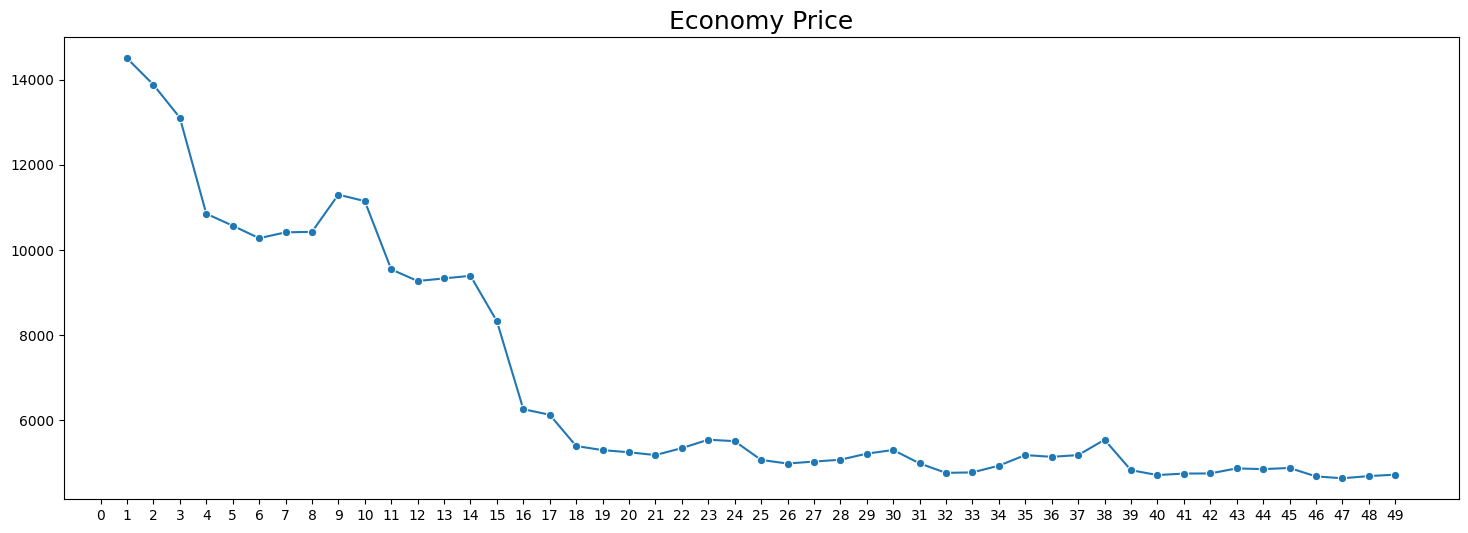

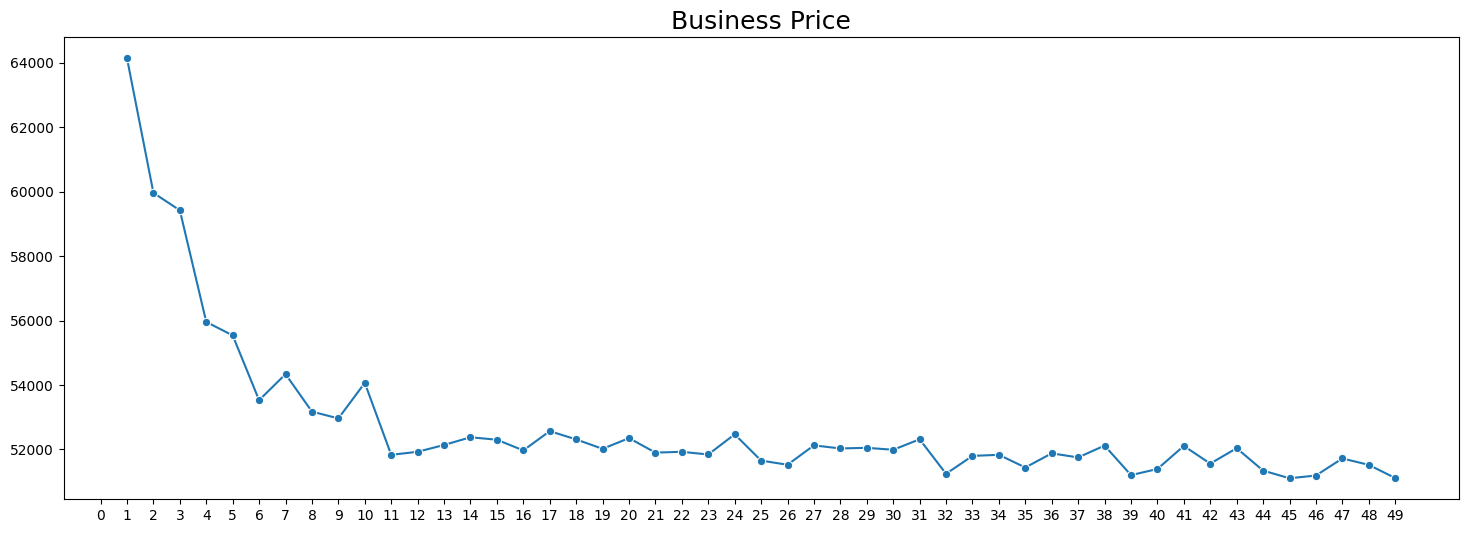

In [105]:
plt.figure(figsize=(18, 6))
sns.lineplot(x='days_left', y='price', data=df[df['class']=='Economy'], marker='o', errorbar=None, palette=my_palette)
plt.title('Economy Price', fontsize=18)
plt.ylabel('')
plt.xlabel('')
plt.xticks(np.arange(0, 50, 1))

plt.figure(figsize=(18, 6))
sns.lineplot(x='days_left', y='price', data=df[df['class']=='Business'], marker='o', errorbar=None, palette=my_palette)
plt.title('Business Price', fontsize=18)
plt.ylabel('')
plt.xlabel('')
plt.xticks(np.arange(0, 50, 1))
plt.show()

- Similar pattern between economy and business class, early book cheaper price.

### What does flight code represent?

**Analyze Character Code**

In [19]:
# Extracting the character code and number code from the flight column
df[['ch_code', 'num_code']] = df['flight'].str.split('-', expand=True)
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,ch_code,num_code
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953,SG,8709
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953,SG,8157
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956,I5,764
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955,UK,995
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955,UK,963


In [20]:
# Check the NULL values on the number code
print('NULL values:', df['num_code'].isnull().sum())

# Check the unique values of the character code
df['ch_code'].value_counts()

NULL values: 51


ch_code
UK    126917
AI     79601
6E     43069
G8     23173
I5     16098
SG      9011
0         51
Name: count, dtype: int64

In [21]:
# Check the 0 character code
df[df['ch_code'] == '0']['airline'].value_counts()

airline
Indigo    51
Name: count, dtype: int64

- There are 51 rows with no flight code and its all came from Indigo Airlines.

In [22]:
# Checking the flight code used by each airline
print('Air_India:', df[df['airline'] == 'Air_India']['ch_code'].unique())
print('SpiceJet:', df[df['airline'] == 'SpiceJet']['ch_code'].unique())
print('IndiGo  :', df[df['airline'] == 'Indigo']['ch_code'].unique())
print('AirAsia :', df[df['airline'] == 'AirAsia']['ch_code'].unique())
print('Vistara :', df[df['airline'] == 'Vistara']['ch_code'].unique())
print('GoFirst :', df[df['airline'] == 'GO_FIRST']['ch_code'].unique())

Air_India: ['AI']
SpiceJet: ['SG']
IndiGo  : ['6E' '0']
AirAsia : ['I5']
Vistara : ['UK']
GoFirst : ['G8']


- Indigo Airlines have two different flight character code. Since it was only 51 Indigo Airlines 0 code, we can change it to '6E'.
- But, since each airlines only have one flight code, this variable will be redundant to airlines name. We will drop the character code.

**Analyze Number Code**

In [23]:
# Check number of unique values and dtype
print('Unique values:', df['num_code'].nunique())
print('Number Code dtype:', df['num_code'].dtype)
df_num_code = df['num_code'].unique()

Unique values: 1253
Number Code dtype: object


In [24]:
# Check top 5 number code
df['num_code'].value_counts().head()

num_code
808    3311
706    3116
772    2830
774    2807
720    2630
Name: count, dtype: int64

In [25]:
# Check airlines that use the same number code
df[df['num_code'] == '808']['airline'].value_counts()

airline
Vistara      1759
Air_India    1470
GO_FIRST       82
Name: count, dtype: int64

In [26]:
df['trip'] = df['source_city'] + ' - ' + df['destination_city']
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,ch_code,num_code,trip
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953,SG,8709,Delhi - Mumbai
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953,SG,8157,Delhi - Mumbai
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956,I5,764,Delhi - Mumbai
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955,UK,995,Delhi - Mumbai
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955,UK,963,Delhi - Mumbai


In [27]:
# Check each source and destination city by the same number code
df_808 = df[(df['num_code'] == '808')]
df_808.groupby(['trip', 'ch_code']).agg({
    'departure_time': 'unique',
    'arrival_time': 'unique',
    'stops': 'unique',
    'flight': 'count',
})

departure_time  \
trip                  ch_code                                  
Bangalore - Chennai   AI                             [Night]   
                      UK                     [Early_Morning]   
Bangalore - Delhi     AI                             [Night]   
                      G8                [Afternoon, Morning]   
                      UK                     [Early_Morning]   
Bangalore - Hyderabad AI                             [Night]   
                      UK                     [Early_Morning]   
Bangalore - Kolkata   AI                             [Night]   
                      G8                [Afternoon, Evening]   
                      UK                     [Early_Morning]   
Bangalore - Mumbai    AI                             [Night]   
                      G8       [Afternoon, Morning, Evening]   
                      UK                     [Early_Morning]   

                                                       arrival_time  \
trip                  ch_code                                         
Bangalore - Chennai   AI       [Night, Evening, Morning, Afternoon]   
                      UK                  [Evening, Night, Morning]   
Bangalore - Delhi     AI                                    [Night]   
                      G8                                  [Evening]   
                      UK                                  [Morning]   
Bangalore - Hyderabad AI                  [Night, Morning, Evening]   
                      UK       [Morning, Afternoon, Evening, Night]   
Bangalore - Kolkata   AI       [Evening, Night, Morning, Afternoon]   
                      G8                                    [Night]   
                      UK                  [Evening, Morning, Night]   
Bangalore - Mumbai    AI       [Morning, Evening, Night, Afternoon]   
                      G8                           [Night, Morning]   
                      UK       [Afternoon, Evening, Night, Morning]   

                                            stops  flight  
trip                  ch_code                              
Bangalore - Chennai   AI                    [one]     203  
                      UK                    [one]     248  
Bangalore - Delhi     AI                   [zero]      98  
                      G8                    [one]      38  
                      UK                   [zero]      97  
Bangalore - Hyderabad AI       [two_or_more, one]     319  
                      UK                    [one]     294  
Bangalore - Kolkata   AI                    [one]     333  
                      G8                    [one]       5  
                      UK                    [one]     243  
Bangalore - Mumbai    AI                    [one]     517  
                      G8                    [one]      39  
                      UK                    [one]     877

In [28]:
# Check each source and destination city by the same number code
df_706 = df[(df['num_code'] == '706')]
df_706.groupby(['trip', 'ch_code']).agg({
    'departure_time': 'unique',
    'arrival_time': 'unique',
    'stops': 'unique',
    'flight': 'count',
})

,,departure_time,arrival_time,stops,flight
trip,ch_code,,,,
Delhi - Bangalore,UK,[Afternoon],"[Evening, Early_Morning, Morning]",[two_or_more],20
Delhi - Hyderabad,UK,[Afternoon],"[Early_Morning, Afternoon]",[two_or_more],7
Delhi - Kolkata,UK,[Afternoon],"[Morning, Evening]",[two_or_more],7
Delhi - Mumbai,UK,[Afternoon],"[Night, Morning]",[one],166
Kolkata - Bangalore,UK,[Morning],"[Evening, Night, Morning]","[one, two_or_more]",551
Kolkata - Chennai,UK,[Morning],"[Evening, Night, Morning]","[one, two_or_more]",462
Kolkata - Delhi,UK,[Morning],[Afternoon],[zero],93
Kolkata - Hyderabad,UK,[Morning],"[Afternoon, Morning, Evening, Night]",[one],590
Kolkata - Mumbai,UK,[Morning],"[Morning, Evening, Afternoon, Night]","[one, two_or_more]",1220


In [29]:
# Check each source and destination city by the same number code
df_772 = df[(df['num_code'] == '772')]
df_772.groupby(['trip', 'ch_code']).agg({
    'departure_time': 'unique',
    'arrival_time': 'unique',
    'stops': 'unique',
    'flight': 'count',
})

,,departure_time,arrival_time,stops,flight
trip,ch_code,,,,
Bangalore - Chennai,AI,[Morning],[Evening],[one],4
Bangalore - Delhi,AI,[Morning],"[Evening, Night]",[one],7
Bangalore - Hyderabad,AI,[Morning],"[Night, Afternoon]",[one],6
Bangalore - Kolkata,AI,[Morning],[Afternoon],[zero],4
Bangalore - Mumbai,AI,[Morning],[Night],[one],4
Delhi - Bangalore,6E,[Early_Morning],[Morning],[zero],44
Delhi - Chennai,6E,[Early_Morning],"[Afternoon, Evening]",[one],50
Kolkata - Bangalore,UK,[Morning],"[Morning, Afternoon, Night, Evening, Early_Mor...",[one],641
Kolkata - Chennai,UK,[Morning],"[Evening, Morning, Night]",[one],367


In [30]:
# Check each source and destination city by the same number code
df_774 = df[(df['num_code'] == '774')]
df_774.groupby(['trip', 'ch_code']).agg({
    'departure_time': 'unique',
    'arrival_time': 'unique',
    'stops': 'unique',
    'flight': 'count',
})

,,departure_time,arrival_time,stops,flight
trip,ch_code,,,,
Kolkata - Bangalore,UK,[Night],"[Morning, Night, Early_Morning, Evening]",[one],545
Kolkata - Chennai,UK,[Night],"[Evening, Morning, Night]",[one],317
Kolkata - Delhi,UK,[Night],"[Evening, Night, Morning, Afternoon, Late_Night]",[one],959
Kolkata - Hyderabad,UK,[Night],"[Night, Afternoon, Early_Morning]",[one],242
Kolkata - Mumbai,UK,[Night],[Night],[zero],81
Mumbai - Bangalore,AI,[Night],"[Night, Late_Night, Evening]",[one],75
Mumbai - Chennai,AI,[Night],"[Night, Evening, Morning, Afternoon]",[one],120
Mumbai - Delhi,AI,[Night],"[Night, Morning, Afternoon, Evening]",[one],274
Mumbai - Hyderabad,AI,[Night],"[Night, Afternoon]",[one],98


In [31]:
# Check each source and destination city by the same number code
df_720 = df[(df['num_code'] == '720')]
df_720.groupby(['trip', 'ch_code']).agg({
    'departure_time': 'unique',
    'arrival_time': 'unique',
    'stops': 'unique',
    'flight': 'count',
})

,,departure_time,arrival_time,stops,flight
trip,ch_code,,,,
Kolkata - Bangalore,UK,[Early_Morning],"[Night, Morning, Evening, Afternoon]","[one, two_or_more]",614
Kolkata - Chennai,UK,[Early_Morning],"[Evening, Night, Morning]",[one],359
Kolkata - Delhi,UK,[Early_Morning],[Morning],[zero],94
Kolkata - Hyderabad,UK,[Early_Morning],"[Night, Afternoon, Evening, Morning]",[one],445
Kolkata - Mumbai,UK,[Early_Morning],"[Night, Afternoon, Evening, Morning]","[one, two_or_more]",1118


- Each number code didn't represent just a single flight route and its schedule. We will remove this column later.

### How does duration and price vary by number of stops?

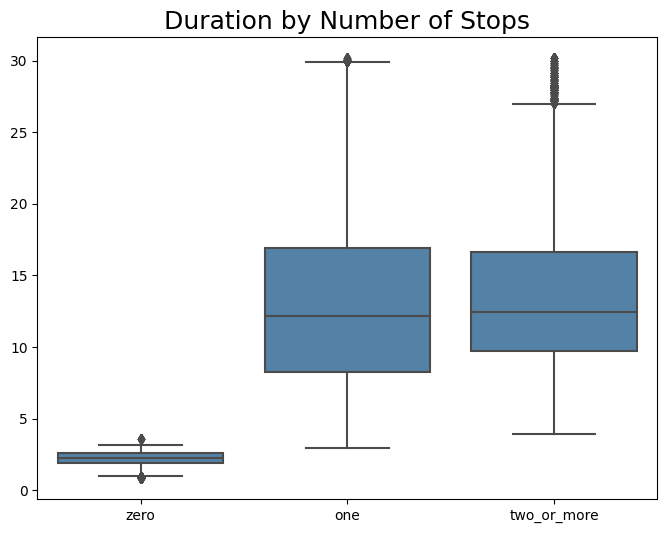

In [32]:
# Duration Distribution by Number of Stops
my_palette = {'#4682B4'}
values = ['zero', 'one', 'two_or_more']
plt.figure(figsize=(8, 6))
sns.boxplot(x='stops', y='duration', data=df, order=values, palette=my_palette)
plt.title('Duration by Number of Stops', fontsize=18)
plt.ylabel('')
plt.xlabel('')
plt.show()

- Most of long duration flights were significantly influenced by the number of stops. This indicates transit flight tend to have longer flight duration

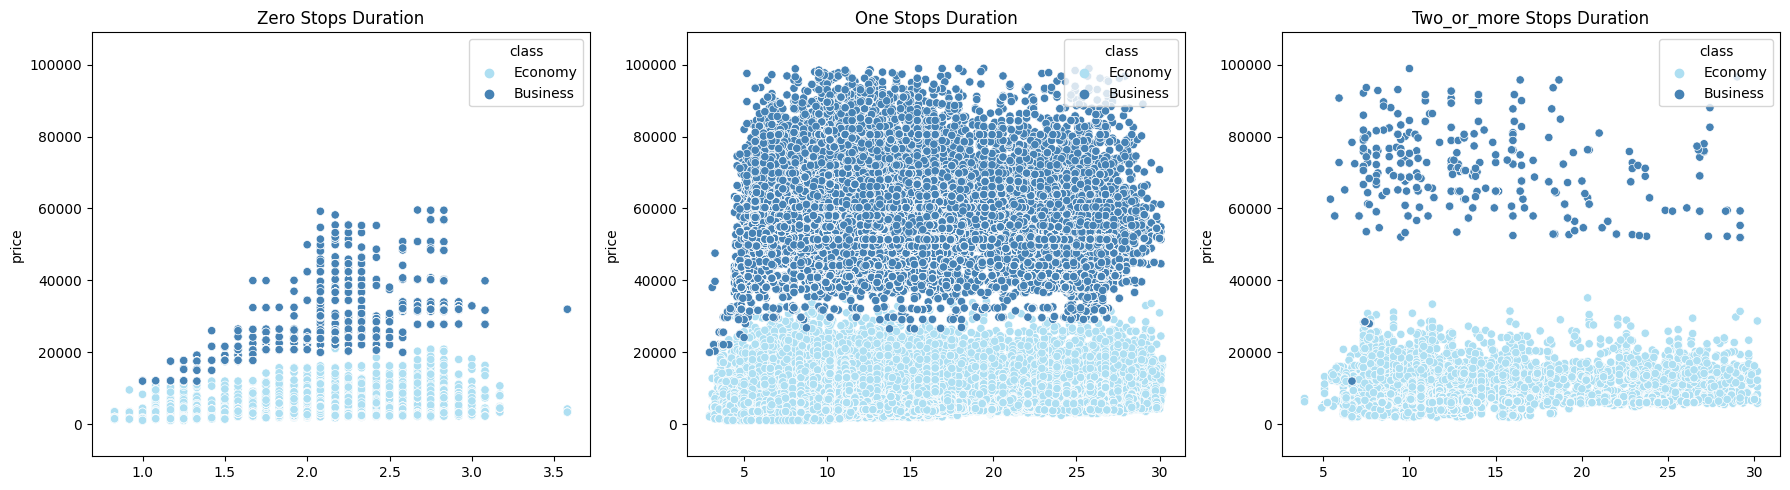

In [33]:
# Price Distribution by Number of Stops
my_palette = {'Business':'#4682B4', 'Economy':'#AEDFF2'}

fig, axs = plt.subplots(1, 3, figsize=(18, 5 * 1))

values = ['zero', 'one', 'two_or_more']
common_ylim = (df['price'].min()-10000, df['price'].max()+10000)

for i, value in enumerate(values):
    ax = axs[i]
    sns.scatterplot(x='duration', y='price', data=df[df['stops'] == value], hue='class', palette=my_palette, ax=ax)
    ax.set_title(f'{value.capitalize()} Stops Duration')
    ax.set_xlabel('')
    ax.set_ylim(common_ylim)

plt.tight_layout()
plt.show()

- Transit flight tends to have higher ticket price.
- Most of the expensive ticket prices were from one stop transit.
- Either business or economy class have both direct and transit flight.
- Majority of the flight schedule were one stop flights.

### What are the highest and lowest demand flight route by schedule?

In [34]:
df['trip'].describe()

count             297920
unique                30
top       Delhi - Mumbai
freq               15289
Name: trip, dtype: object

- Delhi to Mumbai was the highest demand flight route with 15,289 schedules available for the next 49 days.

In [35]:
# Getting the top and bottom 5 trips
my_palette_top = ['#4682B4', '#AEDFF2', '#AEDFF2', '#AEDFF2', '#AEDFF2']
my_palette_bot = ['#AEDFF2', '#AEDFF2', '#AEDFF2', '#AEDFF2', '#4682B4']

top_trip = df['trip'].value_counts().head()
top_trip = pd.DataFrame(top_trip, columns=['count']).reset_index()
bot_trip = df['trip'].value_counts().tail()
bot_trip = pd.DataFrame(bot_trip, columns=['count']).reset_index()

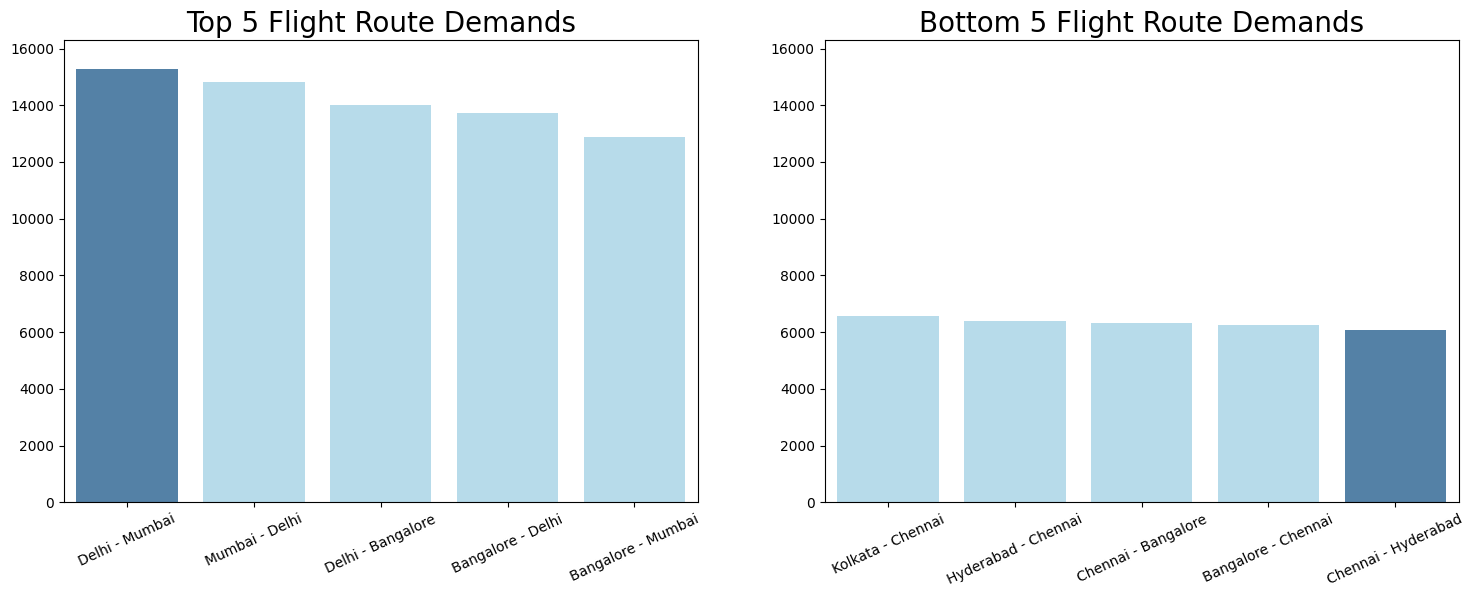

In [36]:
plt.subplots(1, 2, figsize=(18, 6))
plt.subplot(121)
sns.barplot(x='trip', y='count', data=top_trip, palette=my_palette_top)
plt.title('Top 5 Flight Route Demands', fontsize=20)
plt.xticks(rotation=25)
plt.ylim(0, top_trip['count'].max()+1000)
plt.ylabel('')
plt.xlabel('')

plt.subplot(122)
sns.barplot(x='trip', y='count', data=bot_trip, palette=my_palette_bot)
plt.title('Bottom 5 Flight Route Demands', fontsize=20)
plt.xticks(rotation=25)
plt.ylim(0, top_trip['count'].max()+1000)
plt.ylabel('')
plt.xlabel('')

plt.show()

- Delhi to Mumbai was the highest demand flight route followed by Mumbai-Delhi, Delhi-Bangalore, Bangalore-Dellhi, Bangalore-Mumbai.
- Chennai to Hydeerabad was the lowest demand flight route.
- Chennai appears 5/5 in bottom 5 means Chennai have the least flight demand.

### Which flight route have the most expensive and cheapest average price?

In [37]:
# Getting the top and bottom 5 trips
my_palette_top = ['#4682B4', '#AEDFF2', '#AEDFF2', '#AEDFF2', '#AEDFF2']
my_palette_bot = ['#AEDFF2', '#AEDFF2', '#AEDFF2', '#AEDFF2', '#4682B4']

avg_price_trip = df.groupby('trip').agg({'price':'mean'}).reset_index()
top_trip = avg_price_trip.sort_values('price', ascending=False).head()
bot_trip = avg_price_trip.sort_values('price', ascending=True).head()

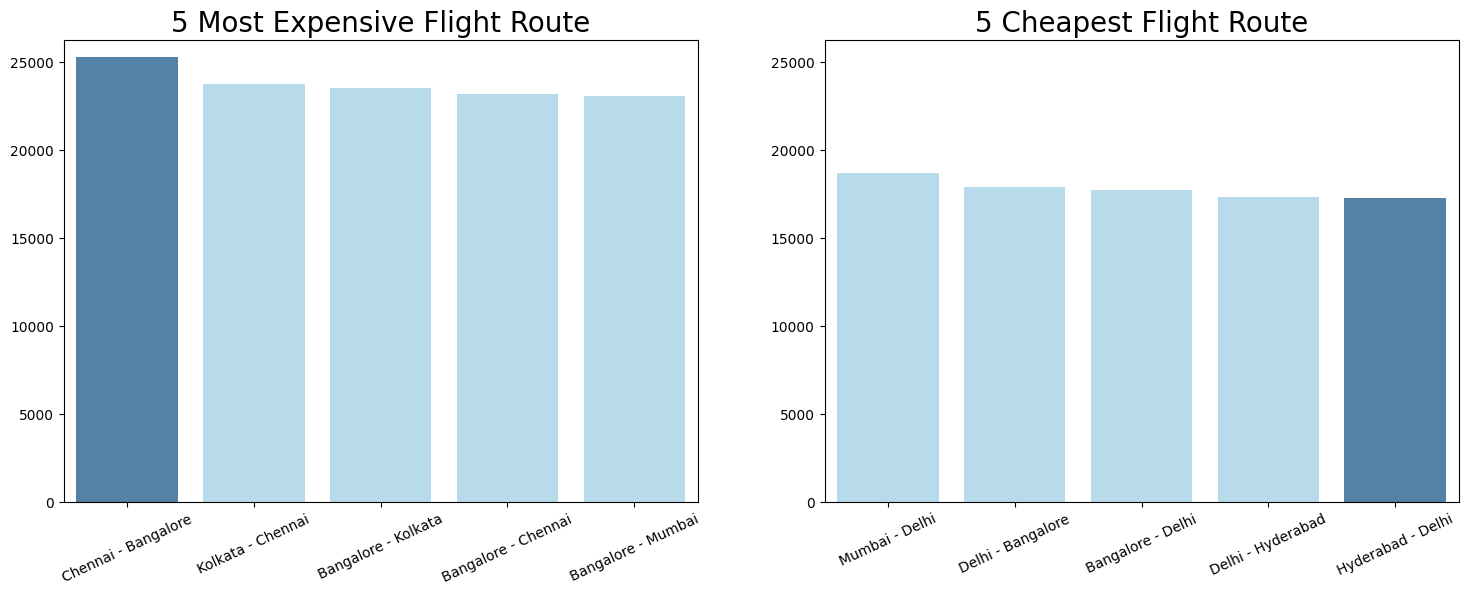

In [38]:
plt.subplots(1, 2, figsize=(18, 6))
plt.subplot(121)
sns.barplot(x='trip', y='price', data=top_trip, palette=my_palette_top)
plt.title('5 Most Expensive Flight Route', fontsize=20)
plt.xticks(rotation=25)
plt.ylim(0, top_trip['price'].max()+1000)
plt.ylabel('')
plt.xlabel('')

plt.subplot(122)
sns.barplot(x='trip', y='price', data=bot_trip.sort_values(by='price', ascending=False), palette=my_palette_bot)
plt.title('5 Cheapest Flight Route', fontsize=20)
plt.xticks(rotation=25)
plt.ylim(0, top_trip['price'].max()+1000)
plt.ylabel('')
plt.xlabel('')

plt.show()

- Chennai to Bangalore was the most expensive fight route while Hyderabad to Delhi was the cheapest.
- Bangalore appears 4/5 in the top 5 flight route by price. We can assume every flight route that includes Bangalore tends to be more expensive.
- Delhi appears 5/5 in the bottom 5 flight route by price. We can assume every flight route that includes Delhi tends to be cheaper.

### Which city is the busiest in the next 49 days?

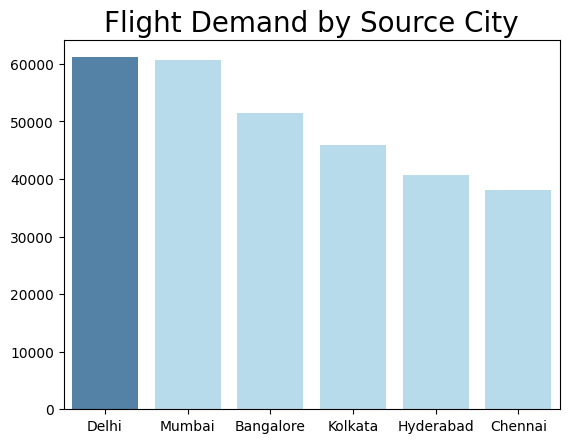

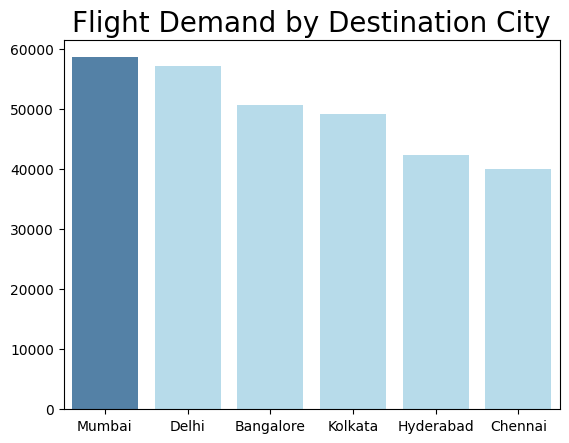

In [39]:
my_palette = ['#4682B4', '#AEDFF2', '#AEDFF2', '#AEDFF2', '#AEDFF2', '#AEDFF2']
sns.countplot(x='source_city', data=df, palette=my_palette)
plt.title('Flight Demand by Source City', fontsize=20)
plt.xlabel('')
plt.ylabel('')
plt.show()

my_palette = ['#4682B4', '#AEDFF2', '#AEDFF2', '#AEDFF2', '#AEDFF2', '#AEDFF2']
sns.countplot(x='destination_city', data=df, palette=my_palette, order=df['destination_city'].value_counts().index)
plt.title('Flight Demand by Destination City', fontsize=20)
plt.xlabel('')
plt.ylabel('')
plt.show()

- Mumbai and Delhi are the busiest cities by its demands.
- The other 4 cities are in the same order by its flight schedule.

### Which city have the most expensive flight price?

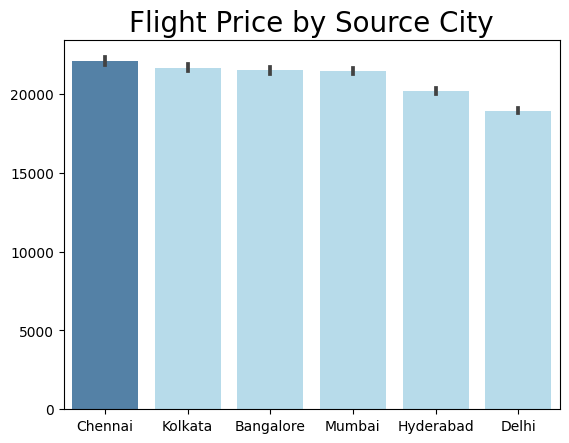

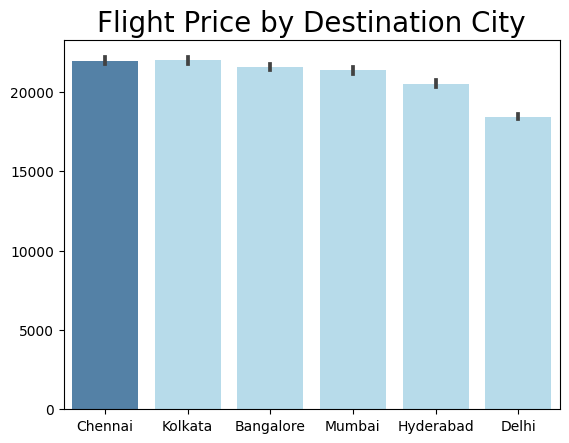

In [40]:
sns.barplot(x='source_city', y='price', data=df, palette=my_palette, estimator=np.mean, order=df.groupby('source_city')['price'].mean().sort_values(ascending=False).index)
plt.title('Flight Price by Source City', fontsize=20)
plt.xlabel('')
plt.ylabel('')
plt.show()

sns.barplot(x='destination_city', y='price', data=df, palette=my_palette, estimator=np.mean, order=df.groupby('source_city')['price'].mean().sort_values(ascending=False).index)
plt.title('Flight Price by Destination City', fontsize=20)
plt.xlabel('')
plt.ylabel('')
plt.show()

- Both source and destination cities have the same order for the cities based on its flight price.
- Delhi became the cheapest and the busiest source city.

### Which airline have the most flight available?

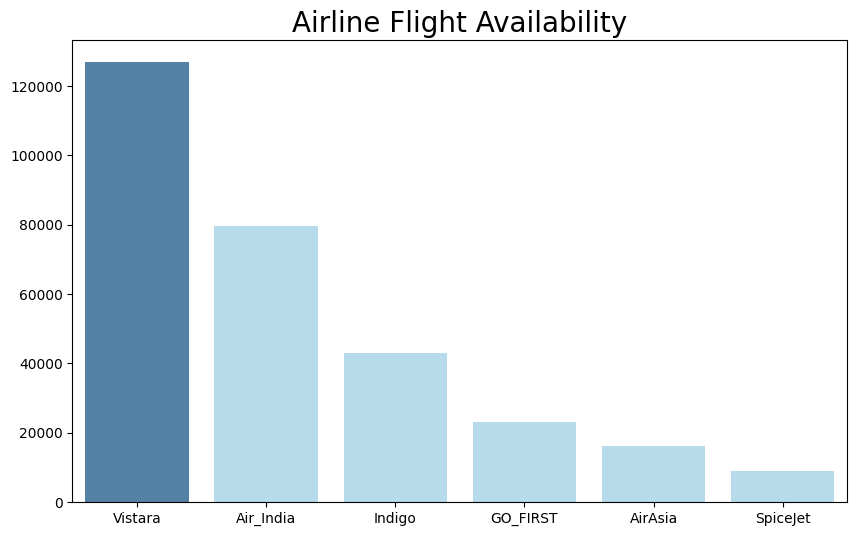

In [41]:
# Airline's number of flight available
my_palette = ['#4682B4', '#AEDFF2', '#AEDFF2', '#AEDFF2', '#AEDFF2', '#AEDFF2']
plt.figure(figsize=(10, 6))
sns.countplot(x='airline', data=df, palette=my_palette, order=df['airline'].value_counts().index)
plt.title('Airline Flight Availability', fontsize=20)
plt.xlabel('')
plt.ylabel('')
plt.show()

- Vistara Airline had the most flight schedule available at the time.

### Which departure time is available for each airline?

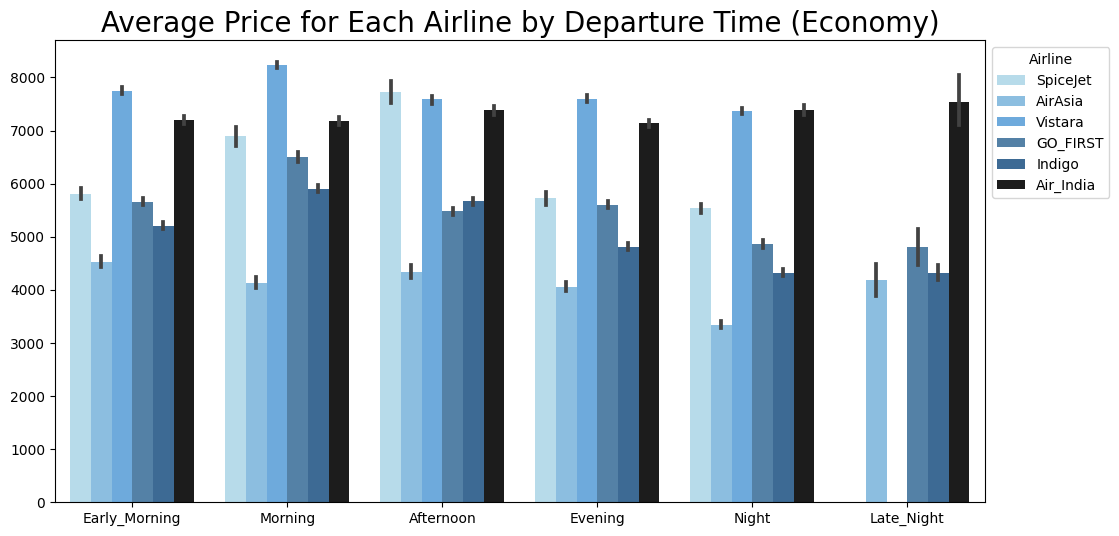

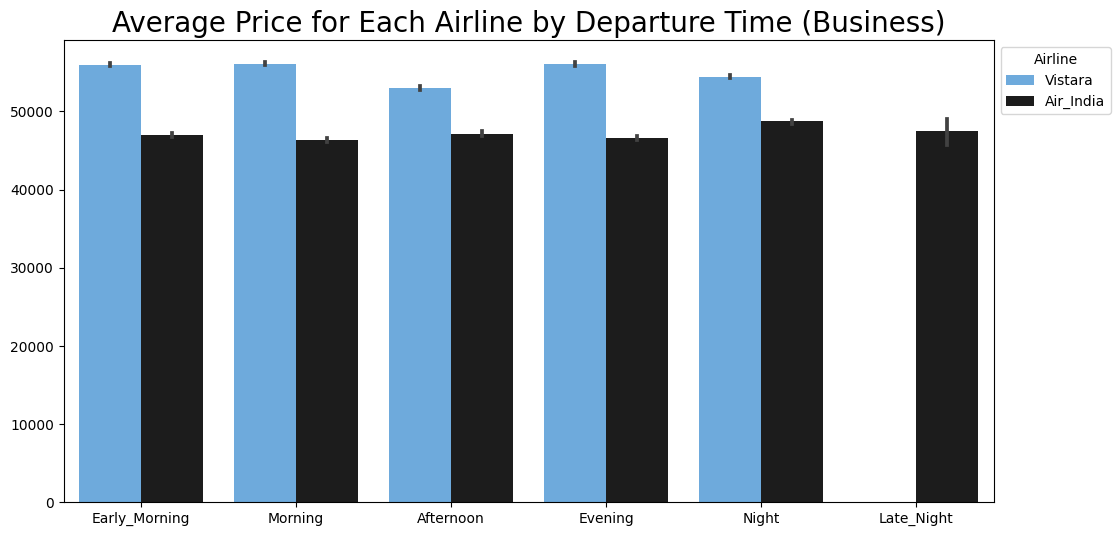

In [42]:
my_palette = ['#AEDFF2', '#7EC0EE', '#5CACEE', '#4682B4', '#2E6AA3', '#1C1C1C']
plt.figure(figsize=(12, 6))
sns.barplot(x='departure_time', y='price', hue='airline', data=df[df['class']=='Economy'], palette=my_palette, estimator=np.mean, order=['Early_Morning', 'Morning', 'Afternoon', 'Evening', 'Night', 'Late_Night'])
plt.title('Average Price for Each Airline by Departure Time (Economy)', fontsize=20)
plt.xlabel('')
plt.ylabel('')
plt.legend(title='Airline', bbox_to_anchor=(1, 1), loc='upper left')

my_palette = {'Vistara':'#5CACEE', 'Air_India':'#1C1C1C'}
plt.figure(figsize=(12, 6))
sns.barplot(x='departure_time', y='price', hue='airline', data=df[df['class']=='Business'], palette=my_palette, estimator=np.mean, hue_order=['Vistara', 'Air_India'], order=['Early_Morning', 'Morning', 'Afternoon', 'Evening', 'Night', 'Late_Night'])
plt.title('Average Price for Each Airline by Departure Time (Business)', fontsize=20)
plt.xlabel('')
plt.ylabel('')
plt.legend(title='Airline', bbox_to_anchor=(1, 1))
plt.show()

- Vistara airline consistently became the most expensive airline on each class, but didn't have late night departure schedule.
- SpiceJet airline also didn't have late night departure schedule.
- Air Asia airline consistently became the cheapest airline on economy class, it mean Air Asia is a recommended airline for budget-friendly trip while its available.

### Which departure time available on each city?

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25124\1146178558.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  source_counts_eco = df[df['class']=="Economy"].groupby(['source_city', 'departure_time']).size().unstack(fill_value=0)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25124\1146178558.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  source_counts_bus = df[df['class']=="Business"].groupby(['source_city', 'departure_time']).size().unstack(fill_value=0)


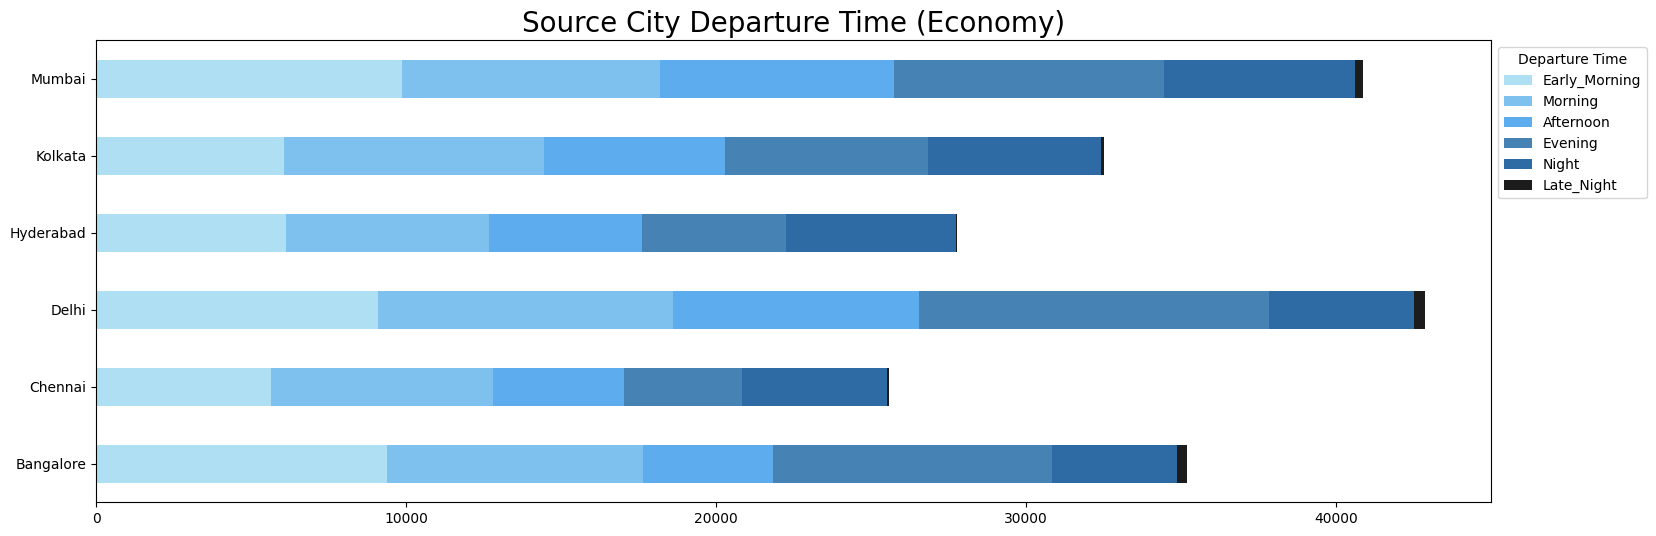

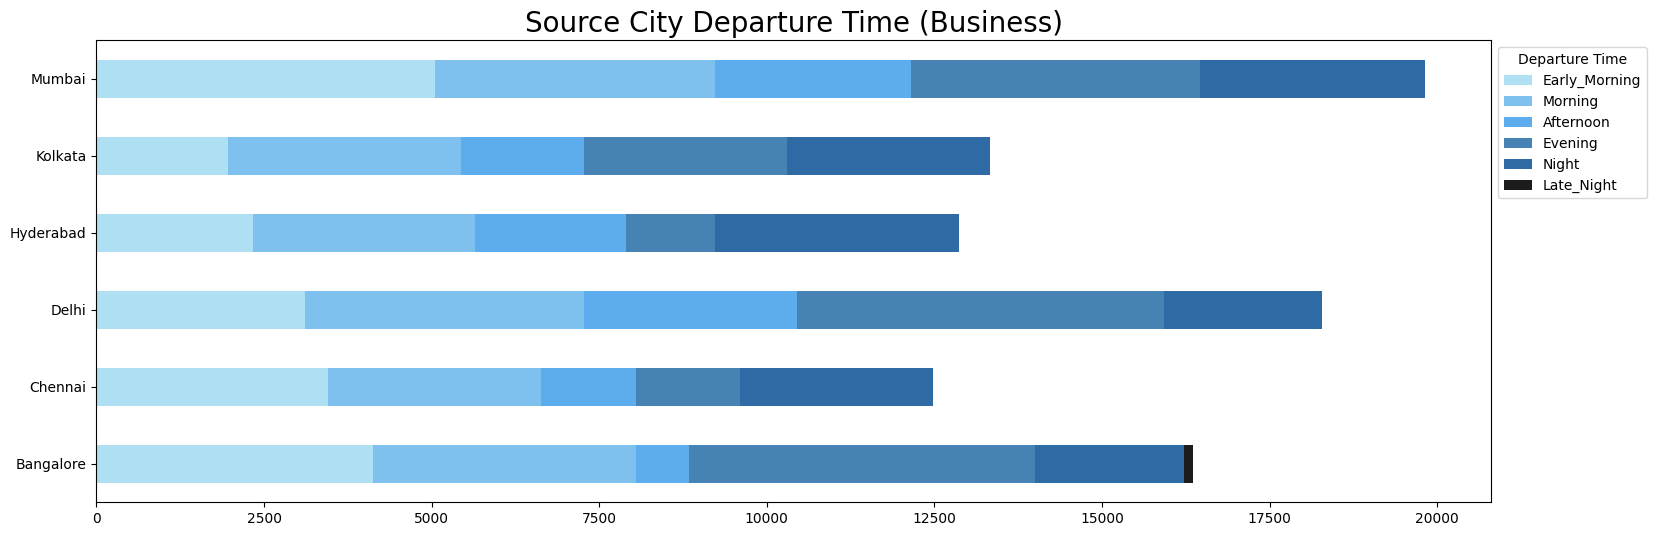

In [43]:
# Ensure the order of departure times
departure_order = ['Early_Morning', 'Morning', 'Afternoon', 'Evening', 'Night', 'Late_Night']
df['departure_time'] = pd.Categorical(df['departure_time'], categories=departure_order, ordered=True)

# Group the data and create a pivot table
source_counts_eco = df[df['class']=="Economy"].groupby(['source_city', 'departure_time']).size().unstack(fill_value=0)
source_counts_eco = source_counts_eco.reindex(columns=departure_order, fill_value=0)
source_counts_bus = df[df['class']=="Business"].groupby(['source_city', 'departure_time']).size().unstack(fill_value=0)
source_counts_bus = source_counts_bus.reindex(columns=departure_order, fill_value=0)

my_palette = ['#AEDFF2', '#7EC0EE', '#5CACEE', '#4682B4', '#2E6AA3', '#1C1C1C']

# Plot for Economy class
source_counts_eco.plot(kind='barh', stacked=True, color=my_palette, figsize=(18, 6))
plt.title('Source City Departure Time (Economy)', fontsize=20)
plt.xlabel('')
plt.ylabel('')
plt.legend(title='Departure Time', bbox_to_anchor=(1, 1))

# Plot for Business class
source_counts_bus.plot(kind='barh', stacked=True, color=my_palette, figsize=(18, 6))
plt.title('Source City Departure Time (Business)', fontsize=20)
plt.xlabel('')
plt.ylabel('')
plt.legend(title='Departure Time', bbox_to_anchor=(1, 1))

plt.show()

### Airline availability on each source city

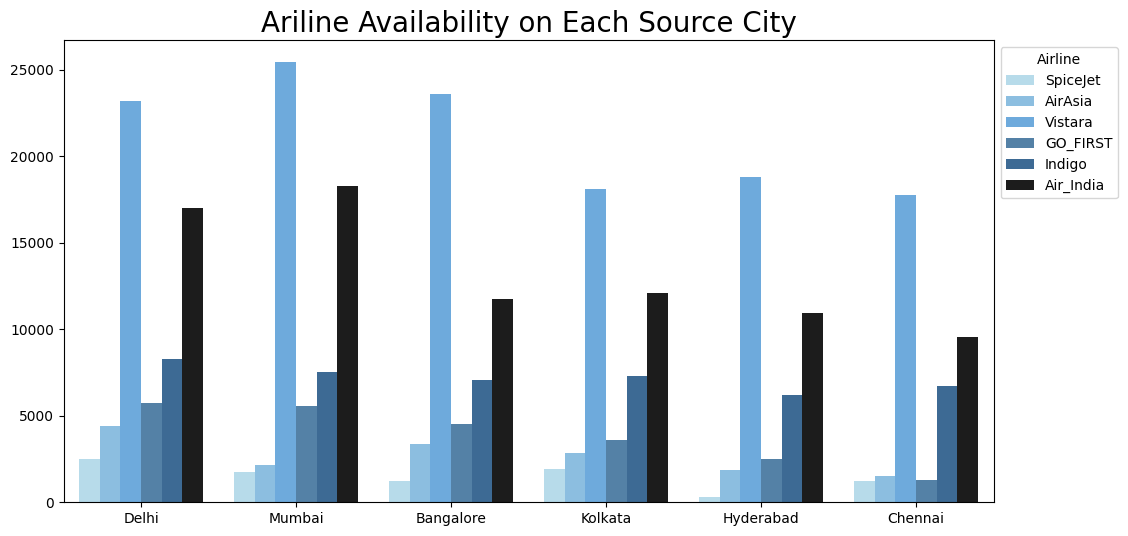

In [44]:
my_palette = ['#AEDFF2', '#7EC0EE', '#5CACEE', '#4682B4', '#2E6AA3', '#1C1C1C']
plt.figure(figsize=(12, 6))
sns.countplot(x='source_city', hue='airline', data=df, palette=my_palette)
plt.title('Ariline Availability on Each Source City', fontsize=20)
plt.xlabel('')
plt.ylabel('')
plt.legend(title='Airline', bbox_to_anchor=(1, 1), loc='upper left')

### Which departure time is the most expensive?

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25124\3560097997.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.barplot(x='departure_time', y='price', data=df[df['class']=='Economy'], palette=my_palette, order=df[df['class']=='Economy'].groupby('departure_time')['price'].mean().sort_values(ascending=False).index)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25124\3560097997.py:11: FutureWarning: The default of observed=Fa

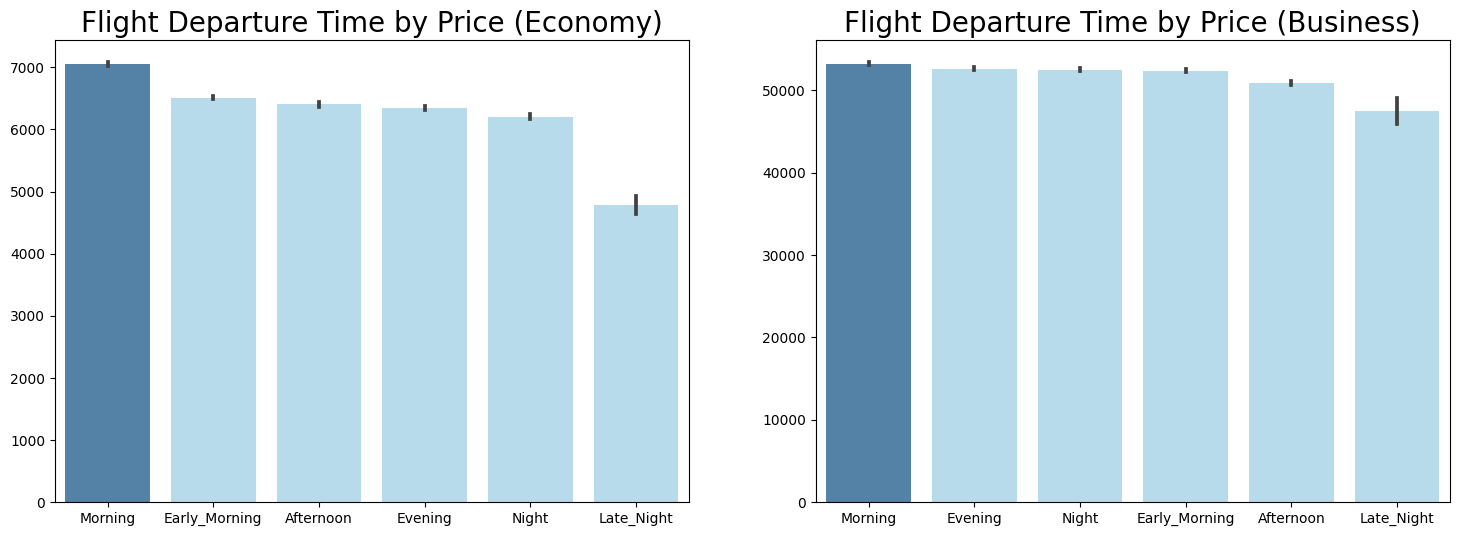

In [45]:
my_palette = ['#4682B4', '#AEDFF2', '#AEDFF2', '#AEDFF2', '#AEDFF2', '#AEDFF2']

plt.subplots(1, 2, figsize=(18, 6))
plt.subplot(121)
sns.barplot(x='departure_time', y='price', data=df[df['class']=='Economy'], palette=my_palette, order=df[df['class']=='Economy'].groupby('departure_time')['price'].mean().sort_values(ascending=False).index)
plt.title('Flight Departure Time by Price (Economy)', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(122)
sns.barplot(x='departure_time', y='price', data=df[df['class']=='Business'], palette=my_palette, order=df[df['class']=='Business'].groupby('departure_time')['price'].mean().sort_values(ascending=False).index)
plt.title('Flight Departure Time by Price (Business)', fontsize=20)
plt.xlabel('')
plt.ylabel('')
plt.show()

- Morning departure time consistently became the most expensive flight on each class.
- Late night departure also consistently became the cheapest flight on each class.
- Late night departure can bi considered as best departure time for budget-friendly trip.

### Which departure time is the busiest?

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


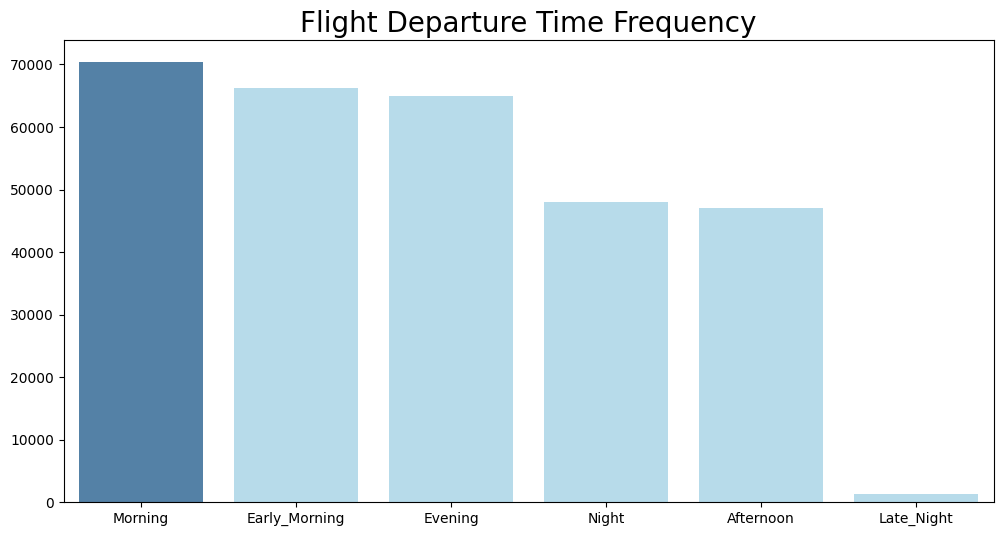

In [46]:
my_palette = ['#4682B4', '#AEDFF2', '#AEDFF2', '#AEDFF2', '#AEDFF2', '#AEDFF2']
plt.figure(figsize=(12, 6))
sns.countplot(x='departure_time', data=df, palette=my_palette, order=df['departure_time'].value_counts().index)
plt.title('Flight Departure Time Frequency', fontsize=20)
plt.xlabel('')
plt.ylabel('')
plt.show()

- Morning departure time became the most expensive because its high demands, while late night became the cheapest because its low demands.

### Numerical variables correlation analysis

<Axes: >

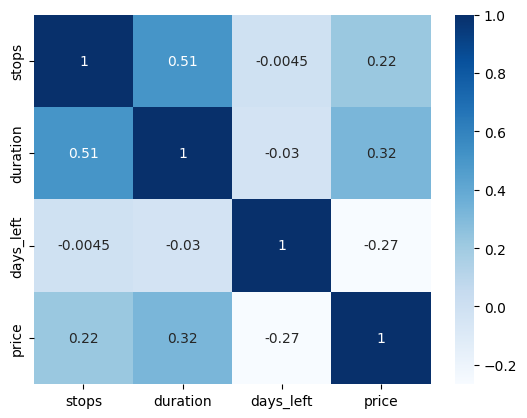

In [47]:
# Convert stops to ordinal number
df_corr = df.copy()
df_corr['stops'] = df['stops'].map({'zero':0, 'one':1, 'two_or_more':2})

# Check correlation
sns.heatmap(df_corr[['stops', 'duration', 'days_left', 'price']].corr(method='spearman'), annot=True, cmap='Blues')

- Spearman correlation between these numerical variables are below 0.5 or -0.5, but we can lower our threshold for these correlation to 0.2 and -0.2 since the data was complex.

# Data Transformation

In [48]:
def transform(data):
    ohe_columns = ['airline', 'source_city', 'destination_city', 'departure_time', 'arrival_time']
    data = pd.get_dummies(data, columns=ohe_columns, prefix=ohe_columns, dtype='float64')

    # Applying binary encoding
    class_mapping = {'Economy': 0, 'Business': 1}
    data['class'] = data['class'].astype(str).map(class_mapping)

    # Applying ordinal encoding
    desired_order = ['zero', 'one', 'two_or_more']
    oe = OrdinalEncoder(categories=[desired_order])
    data['stops'] = oe.fit_transform(data[['stops']])
    
    return data

In [49]:
# Transform the data
df_cleaned = transform(df)

# Drop flight code and trip columns
df_cleaned.drop(['flight', 'ch_code', 'num_code', 'trip'], axis=1, inplace=True)

# Check duplicates after transformation
print('Duplicates:', df_cleaned[df_cleaned.duplicated()].shape[0])
df_cleaned = df_cleaned[~df_cleaned.duplicated()]
df_cleaned = df_cleaned.reset_index(drop=True)
print('Cleaned Dataset Shape:', df_cleaned.shape)
df_cleaned.tail()

Duplicates: 2213
Cleaned Dataset Shape: (295707, 35)


,stops,class,duration,days_left,price,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,...,departure_time_Afternoon,departure_time_Evening,departure_time_Night,departure_time_Late_Night,arrival_time_Afternoon,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night
295702,1.0,1,10.08,49,69265,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
295703,1.0,1,10.42,49,77105,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
295704,1.0,1,13.83,49,79099,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
295705,1.0,1,10.00,49,81585,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
295706,1.0,1,10.08,49,81585,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [50]:
# Save the cleaned dataset
df_cleaned.to_csv('Dataset_Transformed.csv', index=True)

# Modeling

In [51]:
# Define the features and target
x = df_cleaned.drop(['price'], axis=1)
y = df_cleaned['price']

# joblib.dump(x.columns, 'feature_name.joblib')

### Linear Regression

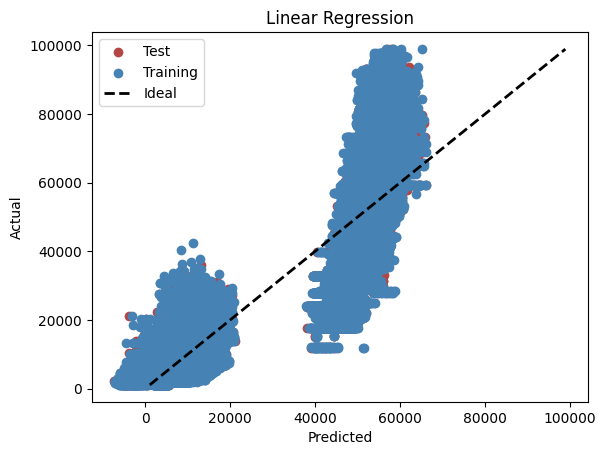

Linear Regression - Test Set Evaluation Metrics:
MAPE: 0.4274010679130761
MAE : 4482.0243312705015
MSE : 45387648.41511954
RMSE: 6737.035580663022
R^2 : 0.9115648106528835



In [52]:
# Splitting the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
# joblib.dump(scaler, 'scaler_lr.joblib')

model = LinearRegression()

# Train the model
model.fit(x_train, y_train)

# Make predictions
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

# Calculate metrics
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

# Visualize the prediction
plt.figure()
plt.scatter(y_test_pred, y_test, c='#B44646', label="Test")
plt.scatter(y_train_pred, y_train, c='#4682B4', label="Training")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label="Ideal")
plt.legend(loc='upper left')
plt.ylabel("Actual")
plt.xlabel("Predicted")

plt.title(f'Linear Regression')
plt.show()

# Print metrics
print(f"Linear Regression - Test Set Evaluation Metrics:")
print(f"MAPE: {mape_test}")
print(f"MAE : {mae_test}")
print(f"MSE : {mse_test}")
print(f"RMSE: {rmse_test}")
print(f"R^2 : {r2_test}\n")

# Save the model
# joblib.dump(model, f'model_lr.joblib')

### Polynomial Regression

In [53]:
# Add Polynomial Features
degree = 2
poly = PolynomialFeatures(degree=degree)

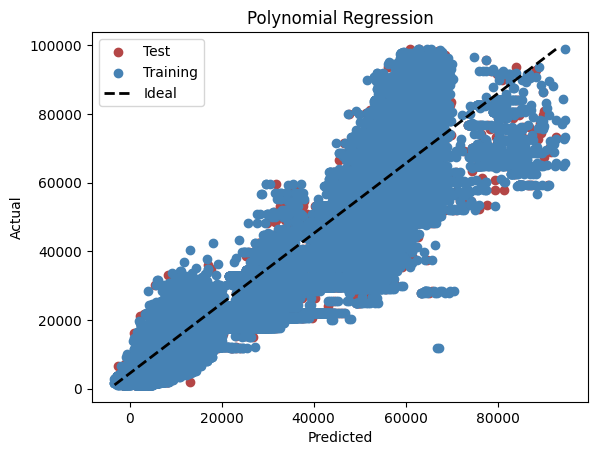

Polynomial Regression - Test Set Evaluation Metrics:
MAPE: 0.2788387162188757
MAE : 3235.5749890095026
MSE : 24903829.131716885
RMSE: 4990.3736465035245
R^2 : 0.9514763394527846


In [54]:
# Splitting the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
# joblib.dump(scaler, 'scaler_poly.joblib')

x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)
# joblib.dump(poly, 'poly.joblib')

model = LinearRegression()

model.fit(x_train_poly, y_train)

y_train_pred = model.predict(x_train_poly)
y_test_pred = model.predict(x_test_poly)

# Calculate metrics
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

# Visualize the prediction
plt.figure()
plt.scatter(y_test_pred, y_test, c='#B44646', label="Test")
plt.scatter(y_train_pred, y_train, c='#4682B4', label="Training")
plt.plot([min(y_test_pred), max(y_test_pred)], [min(y_test), max(y_test)], 'k--', lw=2, label="Ideal")
plt.legend(loc='upper left')
plt.ylabel("Actual")
plt.xlabel("Predicted")

plt.title('Polynomial Regression')
plt.show()

# Print metrics
print("Polynomial Regression - Test Set Evaluation Metrics:")
print(f"MAPE: {mape_test}")
print(f"MAE : {mae_test}")
print(f"MSE : {mse_test}")
print(f"RMSE: {rmse_test}")
print(f"R^2 : {r2_test}")
 

# Save the model
# joblib.dump(model, 'model_poly.joblib')

### Random Forest

In [55]:
# rf_params = {
#     'max_depth': [40, 60, 80],
#     'min_samples_split': [2, 5, 10],
#     'max_features': [0.8, 1],
#     'n_estimators': [400, 450, 550],
#     'random_state': [42],
#     'n_jobs': [-1]
# }

# # Split data into training and testing sets
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# # Apply Grid Search
# grid_rf_search = GridSearchCV(RandomForestRegressor(), rf_params, cv=5, n_jobs=-1, verbose=3)
# grid_rf_search.fit(x_train, y_train)
# print('Best Params:', grid_rf_search.best_params_)
# print('Best Score:', grid_rf_search.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Params: {'max_depth': 60, 'max_features': 0.8, 'min_samples_split': 10, 'n_estimators': 550, 'n_jobs': -1, 'random_state': 42}
Best Score: 0.9865099331293207


In [56]:
best_rf = grid_rf_search.best_estimator_
best_rf

RandomForestRegressor(max_depth=60, max_features=0.8, min_samples_split=10,
                      n_estimators=550, n_jobs=-1, random_state=42)

In [57]:
rf_params = {'max_depth': 60, 'max_features': 0.8, 'min_samples_split': 10, 'n_estimators': 550, 'n_jobs': -1, 'random_state': 42}

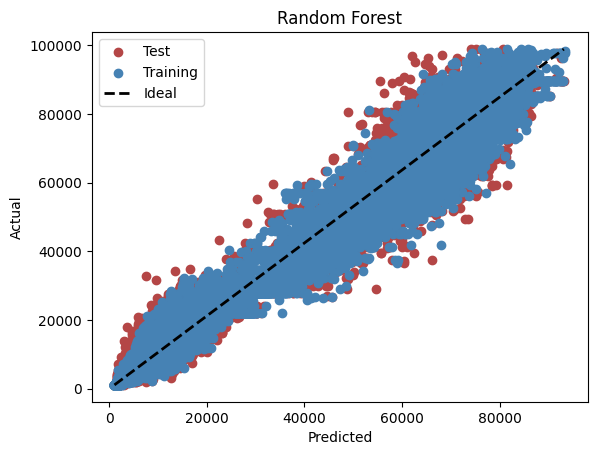

Random Forest - Test Set Evaluation Metrics:
MAPE: 0.07522934977132255
MAE : 1103.4906150908912
MSE : 6577961.889513606
RMSE: 2564.753767813512
R^2 : 0.9872457471732727


In [58]:
# Splitting the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Normalization using MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
# joblib.dump(scaler, 'scaler_rf.joblib')

model = RandomForestRegressor(**rf_params)

model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

# Calculate metrics
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

# Visualize the prediction
plt.figure()
plt.scatter(y_test_pred, y_test, c='#B44646', label="Test")
plt.scatter(y_train_pred, y_train, c='#4682B4', label="Training")
plt.plot([min(y_test_pred), max(y_test_pred)], [min(y_test), max(y_test)], 'k--', lw=2, label="Ideal")
plt.legend(loc='upper left')
plt.ylabel("Actual")
plt.xlabel("Predicted")

plt.title('Random Forest')
plt.show()

# Print metrics
print("Random Forest - Test Set Evaluation Metrics:")
print(f"MAPE: {mape_test}")
print(f"MAE : {mae_test}")
print(f"MSE : {mse_test}")
print(f"RMSE: {rmse_test}")
print(f"R^2 : {r2_test}")

# Save the model
# joblib.dump(model, 'model_rf.joblib')

**Feature Importance**

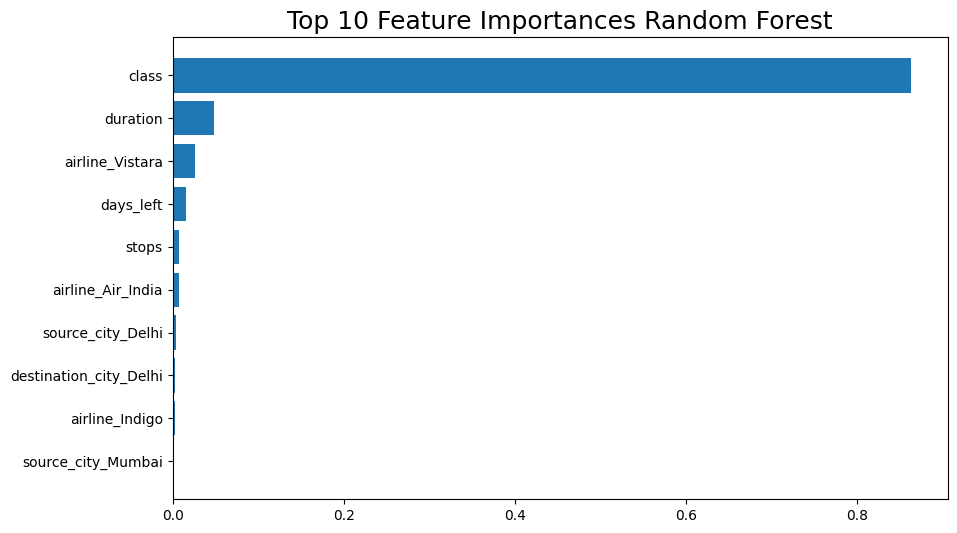

In [59]:
rf_model = joblib.load('model_rf.joblib')
feature_importance = rf_model.feature_importances_

# Get column/feature names
feature_names = x.columns  # Assuming x is your DataFrame of features

# Sort feature importances in descending order
indices = np.argsort(feature_importance)[::-1]

# Get top 10 feature names and importance
top_10_feature_names = feature_names[indices][:10]
top_10_feature_importance = feature_importance[indices][:10]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances Random Forest", fontsize=18)
plt.barh(top_10_feature_names, top_10_feature_importance, align="center")
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
plt.show()

### KNN

In [52]:
knn_params = {
    'n_neighbors': [1, 2, 3, 4, 5],
    'weights': ['uniform'],
    'p': [1]
}

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
grid_knn_search = GridSearchCV(KNeighborsRegressor(), knn_params, cv=5, n_jobs=-1, verbose=2)
grid_knn_search.fit(x_train, y_train)
print('Best Params:', grid_knn_search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Params: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}


In [53]:
best_knn = grid_knn_search.best_estimator_
best_knn

KNeighborsRegressor(p=1)

In [55]:
knn_params = {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}

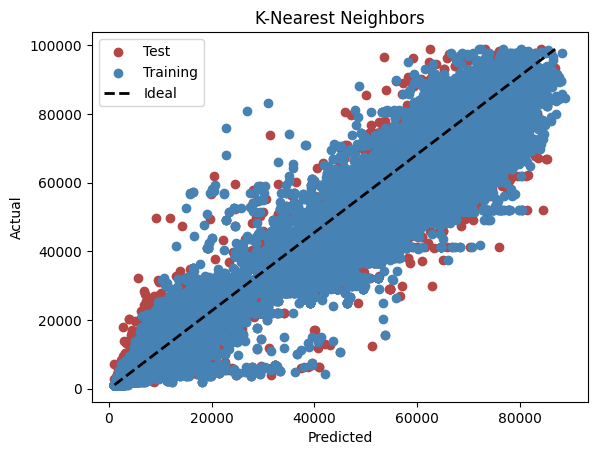

KNN - Test Set Evaluation Metrics:
MAPE: 0.11106528472113279
MAE : 1726.3161239051772
MSE : 12958418.853196038
RMSE: 3599.780389578792
R^2 : 0.9748744439289367


['model_knn.joblib']

In [56]:
# Splitting the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Normalization using MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
# joblib.dump(scaler, 'scaler_knn.joblib')

model = KNeighborsRegressor(**knn_params)

model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

# Calculate metrics
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

# Visualize the prediction
plt.figure()
plt.scatter(y_test_pred, y_test, c='#B44646', label="Test")
plt.scatter(y_train_pred, y_train, c='#4682B4', label="Training")
plt.plot([min(y_test_pred), max(y_test_pred)], [min(y_test), max(y_test)], 'k--', lw=2, label="Ideal")
plt.legend(loc='upper left')
plt.ylabel("Actual")
plt.xlabel("Predicted")

plt.title('K-Nearest Neighbors')
plt.show()

# Print metrics
print("KNN - Test Set Evaluation Metrics:")
print(f"MAPE: {mape_test}")
print(f"MAE : {mae_test}")
print(f"MSE : {mse_test}")
print(f"RMSE: {rmse_test}")
print(f"R^2 : {r2_test}")

# Save the model
# joblib.dump(model, 'model_knn.joblib')

# Predict Data

In [26]:
# Load the models
rf_model = joblib.load('model_rf.joblib')
knn_model = joblib.load('model_knn.joblib')
lr_model = joblib.load('model_lr.joblib')
poly_model = joblib.load('model_poly.joblib')

# Load the scalers and polynomial features
poly = joblib.load('poly.joblib')
scaler_lr = joblib.load('scaler_lr.joblib')
scaler_poly = joblib.load('scaler_poly.joblib')
scaler_rf = joblib.load('scaler_rf.joblib')
scaler_knn = joblib.load('scaler_knn.joblib')

# Load the feature names
feature_name = joblib.load('feature_name.joblib')

In [27]:
def transform(data):
    ohe_columns = ['airline', 'source_city', 'destination_city', 'departure_time', 'arrival_time']
    data = pd.get_dummies(data, columns=ohe_columns, prefix=ohe_columns, dtype='float64')

    # Applying binary encoding
    class_mapping = {'Economy': 0, 'Business': 1}
    data['class'] = data['class'].astype(str).map(class_mapping)

    # Applying ordinal encoding
    desired_order = ['zero', 'one', 'two_or_more']
    oe = OrdinalEncoder(categories=[desired_order])
    data['stops'] = oe.fit_transform(data[['stops']])
    
    return data

In [28]:
# Load dataset to predict
df_transformed = pd.read_csv('Clean_Dataset.csv')
print('Dataset Shape:', df_transformed.shape)
print('Duplicates:', df_transformed[df_transformed.duplicated()].shape[0])
df_transformed.tail()

Dataset Shape: (300153, 12)
Duplicates: 0


,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
300148,300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585
300152,300152,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,81585


In [29]:
# Transform the data
df_transformed = transform(df_transformed)
df_transformed.tail()

,Unnamed: 0,flight,stops,class,duration,days_left,price,airline_AirAsia,airline_Air_India,airline_GO_FIRST,...,departure_time_Evening,departure_time_Late_Night,departure_time_Morning,departure_time_Night,arrival_time_Afternoon,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night
300148,300148,UK-822,1.0,1,10.08,49,69265,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
300149,300149,UK-826,1.0,1,10.42,49,77105,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
300150,300150,UK-832,1.0,1,13.83,49,79099,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
300151,300151,UK-828,1.0,1,10.00,49,81585,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
300152,300152,UK-822,1.0,1,10.08,49,81585,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [30]:
# Original dataset
df_ori = pd.read_csv('Clean_Dataset.csv')
print('Original Data Shape:', df_ori.shape)
df_ori.tail()

Original Data Shape: (300153, 12)


,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
300148,300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585
300152,300152,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,81585


**Define Features and Target**

In [31]:
# Define features and target
x_forpred = df_transformed.drop(['Unnamed: 0', 'flight', 'price'], axis=1)
y_forpred = df_transformed['price']

x_forpred = x_forpred.reindex(columns=feature_name, fill_value=0)

### Linear Regression Prediction

In [32]:
# Scale the features
x_scaled_predict = scaler_lr.transform(x_forpred)

# Create new dataframe to store the predictions
y_baru = pd.DataFrame()
y_predict_new = lr_model.predict(x_scaled_predict)
y_baru['predicted price'] = y_predict_new

# Calculate the evaluation metrics
mae_test = mean_absolute_error(y_forpred, y_predict_new)
mse_test = mean_squared_error(y_forpred, y_predict_new)
rmse_test = np.sqrt(mean_squared_error(y_forpred, y_predict_new))
mape_test = mean_absolute_percentage_error(y_forpred, y_predict_new)
r2_test = r2_score(y_forpred, y_predict_new)

print("Linear Regression - Prediction Evaluation Metrics:")
print(f"MAPE: {mape_test}")
print(f"MSE : {mse_test}")
print(f"MAE : {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"R^2 : {r2_test}")

# # Linear Regression - Prediction Evaluation Metrics:
# # MAPE: 0.4282044787796376
# # MSE : 46381868.57354749
# # MAE : 4515.004261160142
# # RMSE: 6810.423523801401
# # R^2 : 0.9099707967260626

Linear Regression - Prediction Evaluation Metrics:
MAPE: 0.4282044787796376
MSE : 46381868.57354749
MAE : 4515.004261160142
RMSE: 6810.423523801401
R^2 : 0.9099707967260626


In [33]:
df_combined = pd.merge(df_transformed, y_baru[['predicted price']], how='left', left_index=True, right_index=True)
print('Data shape:', df_combined.shape)
df_combined.tail()

Data shape: (300153, 38)


,Unnamed: 0,flight,stops,class,duration,days_left,price,airline_AirAsia,airline_Air_India,airline_GO_FIRST,...,departure_time_Late_Night,departure_time_Morning,departure_time_Night,arrival_time_Afternoon,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night,predicted price
300148,300148,UK-822,1.0,1,10.08,49,69265,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,50333.0
300149,300149,UK-826,1.0,1,10.42,49,77105,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,49741.0
300150,300150,UK-832,1.0,1,13.83,49,79099,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50805.0
300151,300151,UK-828,1.0,1,10.00,49,81585,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,50305.0
300152,300152,UK-822,1.0,1,10.08,49,81585,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,50333.0


In [34]:
# Combine prediction result to new dataframe
df_combined = pd.merge(df_combined[['predicted price', 'Unnamed: 0']], df_ori, how='left', left_on='Unnamed: 0', right_on='Unnamed: 0')
df_combined_lr = df_combined[['airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', \
    'class', 'duration', 'days_left', 'price', 'predicted price']]
df_combined_lr['model'] = 'Linear Regression'

### Polynomial Prediction

In [35]:
# degree = 2
# poly = PolynomialFeatures(degree=degree)

In [36]:
x_scaled_predict = scaler_poly.transform(x_forpred)

x_poly_predict = poly.transform(x_scaled_predict)

# Create new dataframe to store the predictions
y_baru = pd.DataFrame()
y_predict_new = poly_model.predict(x_poly_predict)
y_baru['predicted price'] = np.round(y_predict_new, 2)

# Calculate the evaluation metrics
mae_test = mean_absolute_error(y_forpred, y_predict_new)
mse_test = mean_squared_error(y_forpred, y_predict_new)
rmse_test = np.sqrt(mean_squared_error(y_forpred, y_predict_new))
mape_test = mean_absolute_percentage_error(y_forpred, y_predict_new)
r2_test = r2_score(y_forpred, y_predict_new)

print("Polynomial Regression - Prediction Evaluation Metrics:")
print(f"MAPE: {mape_test}")
print(f"MSE : {mse_test}")
print(f"MAE : {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"R^2 : {r2_test}")

# # Polynomial Regression - Prediction Evaluation Metrics:
# # MAPE: 0.28050410611131166
# # MSE : 25921116.62422498
# # MAE : 3282.668988815704
# # RMSE: 5091.278486217875
# # R^2 : 0.9496859969332775

Polynomial Regression - Prediction Evaluation Metrics:
MAPE: 0.28050410611131166
MSE : 25921116.62422498
MAE : 3282.668988815704
RMSE: 5091.278486217875
R^2 : 0.9496859969332775


In [37]:
df_combined = pd.merge(df_transformed, y_baru[['predicted price']], how='left', left_index=True, right_index=True)
print('Data shape:', df_combined.shape)
df_combined.tail()

Data shape: (300153, 38)


,Unnamed: 0,flight,stops,class,duration,days_left,price,airline_AirAsia,airline_Air_India,airline_GO_FIRST,...,departure_time_Late_Night,departure_time_Morning,departure_time_Night,arrival_time_Afternoon,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night,predicted price
300148,300148,UK-822,1.0,1,10.08,49,69265,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,56044.0
300149,300149,UK-826,1.0,1,10.42,49,77105,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,53600.0
300150,300150,UK-832,1.0,1,13.83,49,79099,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,54544.0
300151,300151,UK-828,1.0,1,10.00,49,81585,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,55076.0
300152,300152,UK-822,1.0,1,10.08,49,81585,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,56044.0


In [38]:
# Combine prediction result to new dataframe
df_combined = pd.merge(df_combined[['predicted price', 'Unnamed: 0']], df_ori, how='left', left_on='Unnamed: 0', right_on='Unnamed: 0')
df_combined_poly = df_combined[['airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', \
    'class', 'duration', 'days_left', 'price', 'predicted price']]
df_combined_poly['model'] = 'Polynomial Regression'

### Random Forest Prediction

In [39]:
x_scaled_predict = scaler_rf.transform(x_forpred)

# Create new dataframe to store the predictions
y_baru = pd.DataFrame()
y_predict_new = rf_model.predict(x_scaled_predict)
y_baru['predicted price'] = np.round(y_predict_new, 2)

# Calculate the evaluation metrics
mae_test = mean_absolute_error(y_forpred, y_predict_new)
mse_test = mean_squared_error(y_forpred, y_predict_new)
rmse_test = np.sqrt(mean_squared_error(y_forpred, y_predict_new))
mape_test = mean_absolute_percentage_error(y_forpred, y_predict_new)
r2_test = r2_score(y_forpred, y_predict_new)

print("Random Forest - Prediction Evaluation Metrics:")
print(f"MAPE: {mape_test}")
print(f"MSE : {mse_test}")
print(f"MAE : {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"R^2 : {r2_test}")

# # Random Forest - Prediction Evaluation Metrics:
# # MAPE: 0.05885176456996462
# # MSE : 4509913.548031331
# # MAE : 877.828375057813
# # RMSE: 2123.6557037409175
# # R^2 : 0.9912460636871546

Random Forest - Prediction Evaluation Metrics:
MAPE: 0.05885176456996462
MSE : 4509913.548031331
MAE : 877.828375057813
RMSE: 2123.6557037409175
R^2 : 0.9912460636871546


In [40]:
df_combined = pd.merge(df_transformed, y_baru[['predicted price']], how='left', left_index=True, right_index=True)
print('Data shape:', df_combined.shape)
df_combined.tail()

Data shape: (300153, 38)


,Unnamed: 0,flight,stops,class,duration,days_left,price,airline_AirAsia,airline_Air_India,airline_GO_FIRST,...,departure_time_Late_Night,departure_time_Morning,departure_time_Night,arrival_time_Afternoon,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night,predicted price
300148,300148,UK-822,1.0,1,10.08,49,69265,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,75160.57
300149,300149,UK-826,1.0,1,10.42,49,77105,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,73718.03
300150,300150,UK-832,1.0,1,13.83,49,79099,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,77700.31
300151,300151,UK-828,1.0,1,10.00,49,81585,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,81284.95
300152,300152,UK-822,1.0,1,10.08,49,81585,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,75160.57


In [41]:
# Combine prediction result to new dataframe
df_combined = pd.merge(df_combined[['predicted price', 'Unnamed: 0']], df_ori, how='left', left_on='Unnamed: 0', right_on='Unnamed: 0')
df_combined_rf = df_combined[['airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', \
    'class', 'duration', 'days_left', 'price', 'predicted price']]
df_combined_rf['model'] = 'Random Forest'

### KNN Prediction

In [42]:
x_scaled_predict = scaler_knn.fit_transform(x_forpred)

# Create new dataframe to store the predictions
y_baru = pd.DataFrame()
y_predict_new = knn_model.predict(x_scaled_predict)
y_baru['predicted price'] = np.round(y_predict_new, 2)

# Calculate the evaluation metrics
mae_test = mean_absolute_error(y_forpred, y_predict_new)
mse_test = mean_squared_error(y_forpred, y_predict_new)
rmse_test = np.sqrt(mean_squared_error(y_forpred, y_predict_new))
mape_test = mean_absolute_percentage_error(y_forpred, y_predict_new)
r2_test = r2_score(y_forpred, y_predict_new)

print("KNN - Prediction Evaluation Metrics:")
print(f"MAPE: {mape_test}")
print(f"MSE : {mse_test}")
print(f"MAE : {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"R^2 : {r2_test}")

# # KNN - Prediction Evaluation Metrics:
# # MAPE: 0.12079696574628214
# # MSE : 17864727.80581357
# # MAE : 2010.6154801051468
# # RMSE: 4226.668641591575
# # R^2 : 0.9653237943936476

KNN - Prediction Evaluation Metrics:
MAPE: 0.12079696574628214
MSE : 17864727.80581357
MAE : 2010.6154801051468
RMSE: 4226.668641591575
R^2 : 0.9653237943936476


In [43]:
df_combined = pd.merge(df_transformed, y_baru[['predicted price']], how='left', left_index=True, right_index=True)
print('Data shape:', df_combined.shape)
df_combined.tail()

Data shape: (300153, 38)


,Unnamed: 0,flight,stops,class,duration,days_left,price,airline_AirAsia,airline_Air_India,airline_GO_FIRST,...,departure_time_Late_Night,departure_time_Morning,departure_time_Night,arrival_time_Afternoon,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night,predicted price
300148,300148,UK-822,1.0,1,10.08,49,69265,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,64605.8
300149,300149,UK-826,1.0,1,10.42,49,77105,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,48272.2
300150,300150,UK-832,1.0,1,13.83,49,79099,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,57868.4
300151,300151,UK-828,1.0,1,10.00,49,81585,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,71124.2
300152,300152,UK-822,1.0,1,10.08,49,81585,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,64605.8


In [44]:
# Combine prediction result to new dataframe
df_combined = pd.merge(df_combined[['predicted price', 'Unnamed: 0']], df_ori, how='left', left_on='Unnamed: 0', right_on='Unnamed: 0')
df_combined_knn = df_combined[['airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', \
    'class', 'duration', 'days_left', 'price', 'predicted price']]
df_combined_knn['model'] = 'KNeighbors'    

### Combine Results

In [45]:
# Combine all models
df_combined = pd.concat([df_combined_lr, df_combined_poly, df_combined_rf], axis=0)
print('Data shape:', df_combined.shape)
df_combined.tail()

Data shape: (900459, 13)


,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,predicted price,model
300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265,75160.57,Random Forest
300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105,73718.03,Random Forest
300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099,77700.31,Random Forest
300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585,81284.95,Random Forest
300152,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,81585,75160.57,Random Forest


In [46]:
# Export the prediction results
# df_combined.to_csv('Prediction Results Final.csv', index=False)